# BayesHW4
# 2021321148 Insik Cho
## Table of contents


1. Binomial regression and grid sampling with bioassay data 
2. CH3. 11.
1.   Importance sampling with normal distribution as a proposal for Bioassay model 

1. CH11.2. MHsampling with bioassay data

2.   Gibbs sampling illustration 
3.   Metropolis sampling + convergence 1
4. Metropolis sampling + convergence 2
5. Derive inverse CDF method for Weibull distribution
6. Implement Box-muller
9. CH10. 3
10. CH10. 2(a~d)
11. CH10.4




In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import numpy as np
import pandas as pd 
import scipy.stats as sps
import sympy
from IPython.display import Image
from scipy.stats import cauchy
from scipy.stats import gamma
from scipy.special import expit #logistic
from scipy import optimize, stats, linalg
import math

import sinvchi2
import plot_tools
import arviz as az
import psis

## 1.Binomial regression and grid sampling with bioassay data 

I referenced https://github.com/avehtari/BDA_py_demos/blob/master/demos_ch3/demo3_6.ipynb



In [2]:
# edit default plot settings
plt.rc('font', size=12)
plt.style.use(plot_tools.custom_styles['gray_background'])

In [3]:
rng = np.random.RandomState(42)

In [4]:
# Bioassay data form the book
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

Text(0, 0.5, 'proportion of deaths')

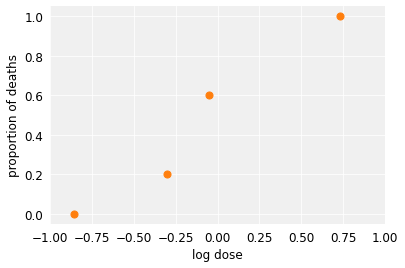

In [5]:
# Check how the data looks

plt.scatter(x, y/n, 50, color = 'C1')
plt.xlim((-1,1))
plt.xlabel('log dose')
plt.ylabel(('proportion of deaths'))

## data explanation

By the book, data are like:

$x_i$ : dose level, one of total of k levels

$n_i$ : number of animals treated $x_i$ 

$y_i$ : outcome. 1 if dead, 0 if alive



Also, $y_i$ us exchangable and independen inside each level i. Therefore, we can assume; 

$y_i | \theta_i $ ~ $Binomial(n_i, \theta_i) $ 

By the book, we also assume that level specific rate $\theta_i$ is a function of $x_i$, a dose level. We use simply logit link function, 

$logit(\theta _i)$ = $log  \frac{\theta_i}{1-\theta_i}$ = $\alpha + \beta x_i$  <->  $\theta_i$ = $ \frac{1}{1+e^{- \alpha -\beta x_i }}$

Summing up, Likelihood is looks like;

p($y_i$ | $\alpha, \beta, n_i , x_i $) $\propto$ $\left[\frac{1}{1+e^{- \alpha -\beta x_i }} \right]^{y_i} \left[ 1-\frac{1}{1+e^{- \alpha -\beta x_i }} \right] ^{n_i -y_i } $ 

Suppose uniform prior $p(\alpha, \beta ) \propto 1 $, then posterior will look like

$p(\alpha, \beta|y) \propto \Pi_i  \left[\frac{1}{1+e^{- \alpha -\beta x_i }} \right]^{y_i} \left[ 1-\frac{1}{1+e^{- \alpha -\beta x_i }} \right] ^{n_i -y_i } $ 

In [6]:
# posterior density used for gird 

gridA = np.linspace(-6,6,100)
gridB = np.linspace(-10,40,100)
ilogit_ABx = 1 / (np.exp(-(gridA[:,None] + gridB[:,None,None] * x)) + 1)
p = np.prod(ilogit_ABx**y * (1 - ilogit_ABx)**(n - y), axis=2)

Sample 1000 points, form standardized posterior(summing to 1).

Use this to sammple

In [7]:
#sampling from grid

nsamp = 1000
samp_indices = np.unravel_index(
    rng.choice(p.size, size=nsamp, p=p.ravel()/np.sum(p)),
    p.shape
)
#확률은 posterior를 사용
samp_A = gridA[samp_indices[1]]
samp_B = gridB[samp_indices[0]]
# add random jitter, see BDA3 p. 76 
# rough estimate to know where to look 
samp_A += (rng.rand(nsamp) - 0.5) * (gridA[1]-gridA[0])
samp_B += (rng.rand(nsamp) - 0.5) * (gridB[1]-gridB[0])

# samples of LD50 conditional beta > 0
bpi = samp_B > 0
samp_ld50 = -samp_A[bpi]/samp_B[bpi]

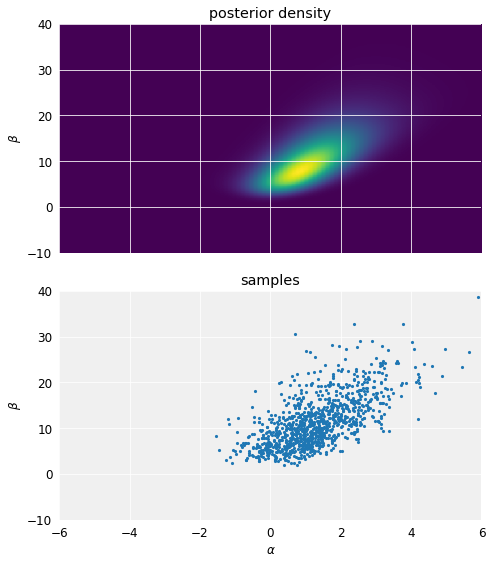

In [8]:
# create figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot the posterior density
ax = axes[0]
ax.imshow(p, origin='lower', aspect='auto', extent=(gridA[0], gridA[-1], gridB[0], gridB[-1]))
ax.set_xlim([-6,6])
ax.set_ylim([-10,40])
ax.set_ylabel(r'$\beta$')
ax.grid('off')
ax.set_title('posterior density')

# plot the samples
ax = axes[1]
ax.scatter(samp_A, samp_B, 10, linewidth=0)
ax.set_xlim([-6,6])
ax.set_ylim([-10,40])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_title('samples')

fig.tight_layout()

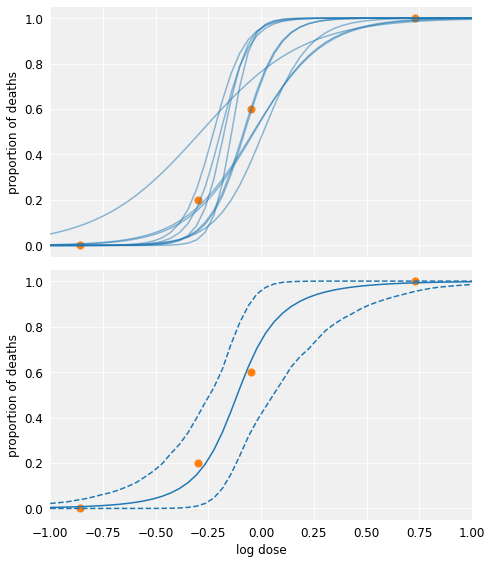

In [9]:
# plot samples with the data
xt = np.linspace(-1, 1)
fs = expit(samp_A[:, None] + samp_B[:, None]*xt)

# ceate figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot 10 first samples
ax = axes[0]
ax.plot(xt, fs[:10].T, color='C0', alpha=0.5)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_ylabel('proportion of deaths')

# plot mean and [5% 95%] interval
# two dotted line are interval lines
ax = axes[1]
ax.plot(xt, np.mean(fs, axis=0).T, color='C0')
ax.plot(
    xt,
    np.percentile(fs, [5, 95], axis=0).T,
    color='C0',
    linestyle='--'
)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_xlabel('log dose')
ax.set_ylabel('proportion of deaths')

fig.tight_layout()

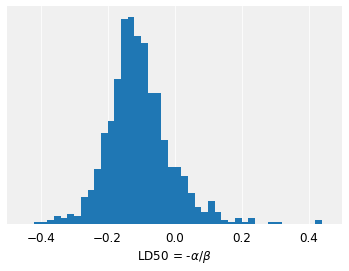

In [10]:
# plot the histogram of LD50
plt.hist(samp_ld50, np.arange(-0.5, 0.51, 0.02))
plt.xlim([-0.5, 0.5])
plt.xlabel(r'LD50 = -$\alpha/\beta$')
plt.yticks(());

##2. CH3.11



(a)

The information of prior is comprised to 

$ \begin{bmatrix}\alpha \\ \beta\end{bmatrix} $ ~ $\left(  \begin{bmatrix}0 \\ 10 \end{bmatrix} , \begin{bmatrix}4 & 10  \\ 10 & 100  \end{bmatrix} \right)$

Then, log posterior will be shaped as

$log p(\alpha, \beta|y) = \Sigma_i (y_i log[\frac{1}{1+e^{- \alpha -\beta x_i }}] + (n_i - y_i ) [1-\frac{1}{1+e^{- \alpha -\beta x_i }}]) + (-\frac{1}{2}(\theta - \mu )^T \Sigma^{-1} (\theta - \mu ) )+ Const. $

In [11]:
# Data
# Bioassay data form the book
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

# information of prior
mu = np.array([0,10])
invsig = np.linalg.inv(np.array([[4,10], [10,100]]))


In [12]:
a = np.linspace(-6,6, 100)
b = np.linspace(-10,40,100)

#calculate prior

def lognorm(theta, mu, invsig):
  a = 0.5 * np.log(np.linalg.det(invsig)) - (mu.size)/2 * np.log(2*math.pi)-0.5*np.transpose(theta - mu) @ invsig @ (theta - mu)
  return a

prior=[]
for i,j in zip(np.repeat(a, len(b)), np.tile(b,len(a))):
  theta = np.array([i,j])
  prior.append(lognorm(theta,mu,invsig))
prior = np.array(prior)

ilogit_ABx = 1 / (np.exp(-(a[:,None] + b[:,None,None] * x)) + 1)
p = np.prod(ilogit_ABx**y * (1 - ilogit_ABx)**(n - y), axis=2)

pp = np.exp(np.log(p.ravel()) + prior)  ## add prior

In [13]:
nsamp = 1000

samp_indices = np.unravel_index(
    rng.choice(p.size, size=nsamp, p=pp.ravel()/np.sum(pp)),
    p.shape)

samp_C = a[samp_indices[1]]
samp_D = b[samp_indices[0]]
# add random jitter, see BDA3 p. 76
# rough estimate to know where to look 
samp_C += (rng.rand(nsamp) - 0.5) * (a[1]-b[0])
samp_D += (rng.rand(nsamp) - 0.5) * (b[1]-b[0])

# samples of LD50 conditional beta > 0
bpi = samp_D > 0
samp_ld50 = -samp_C[bpi]/samp_D[bpi]

## Get samp for likelihood, to use in (b)

samp_indices = np.unravel_index(
    rng.choice(p.size, size=nsamp, p=prior/np.sum(prior)),
    p.shape)

samp_E = a[samp_indices[1]]
samp_F = b[samp_indices[0]]

samp_E += (rng.rand(nsamp) - 0.5) * (a[1]-b[0])
samp_F += (rng.rand(nsamp) - 0.5) * (b[1]-b[0])


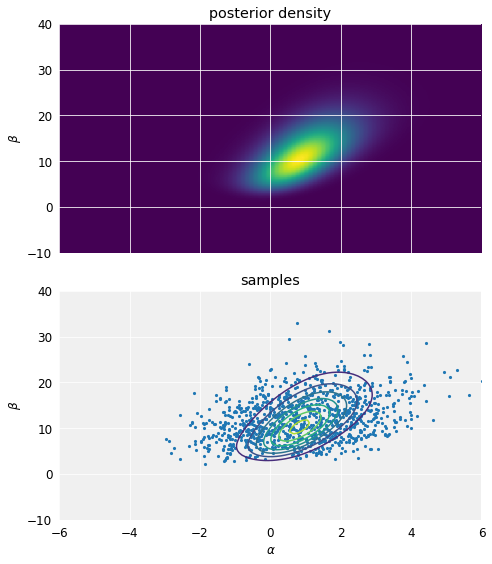

In [14]:
# create figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot the posterior density
ax = axes[0]
ax.imshow(pp.reshape(100,100), origin='lower', aspect='auto', extent=(a[0], a[-1],b [0], b[-1]))
ax.set_xlim([-6,6])
ax.set_ylim([-10,40])
ax.set_ylabel(r'$\beta$')
ax.grid('off')
ax.set_title('posterior density')

# plot the samples
ax = axes[1]
ax.scatter(samp_C, samp_D, 10, linewidth=0)
#contour the samples
ax.contour(a,b, pp.reshape(100,100))
ax.set_xlim([-6,6])
ax.set_ylim([-10,40])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_title('samples')

fig.tight_layout()

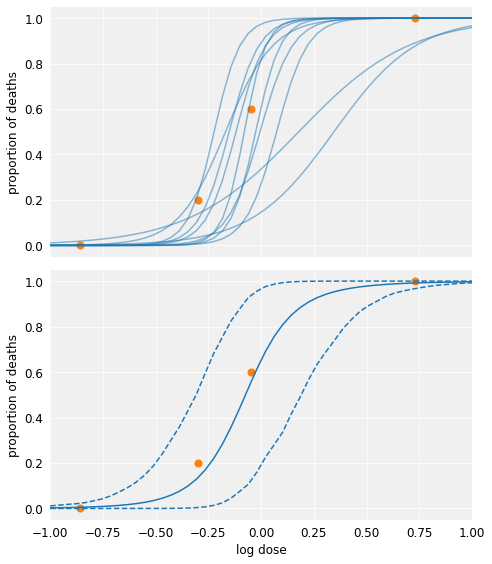

In [15]:
# plot samples with the data
xt = np.linspace(-1, 1)
fs = expit(samp_C[:, None] + samp_D[:, None]*xt)

# ceate figure
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

# plot 10 first samples
ax = axes[0]
ax.plot(xt, fs[:10].T, color='C0', alpha=0.5)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_ylabel('proportion of deaths')

# plot mean and [5% 95%] interval
# two dotted line are interval lines
ax = axes[1]
ax.plot(xt, np.mean(fs, axis=0).T, color='C0')
ax.plot(
    xt,
    np.percentile(fs, [5, 95], axis=0).T,
    color='C0',
    linestyle='--'
)
ax.scatter(x, y/n, 50, color='C1')
ax.set_xlim((-1, 1))
ax.set_xlabel('log dose')
ax.set_ylabel('proportion of deaths')

fig.tight_layout()

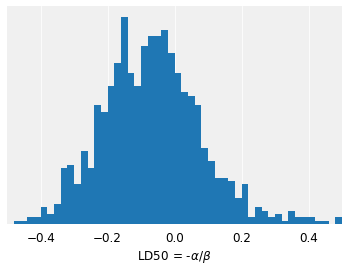

In [16]:
plt.hist(samp_ld50, np.arange(-0.5, 0.51, 0.02))
plt.xlim([-0.5, 0.5])
plt.xlabel(r'LD50 = -$\alpha/\beta$')
plt.yticks(());

(b)

'p' I used over here is equivalent to likelihood, so I will use it for comparing.

From the graphs, I could see that posterior contour (scatter too, not clearly visible though) is located in between likelihood and prior

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'label'
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'label'
  


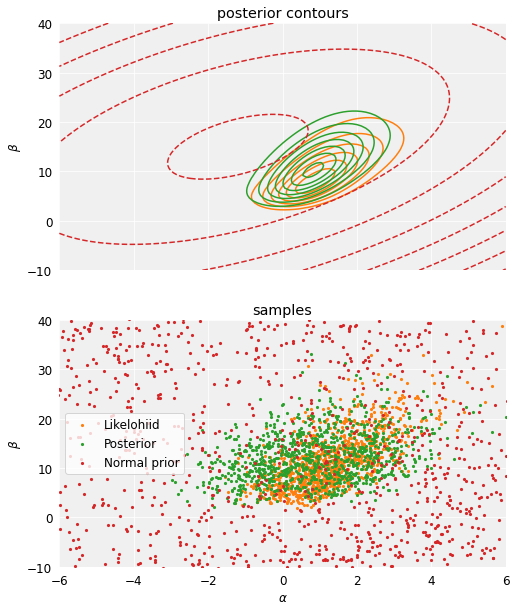

In [17]:
fig, axes = plt.subplots(2,1, figsize=(8, 10), sharex=True)

ax = axes[0]
ax.contour(a,b, p, colors = 'C1', label = 'Likelihood')
ax.contour(a,b, pp.reshape(100,100), colors = 'C2', label = 'posterior')
ax.contour(a,b, prior.reshape(100,100), colors = 'C3',  label = 'Normal prior')
ax.set_xlim([-6,6])
ax.set_ylim([-10,40])
ax.set_ylabel(r'$\beta$')
ax.grid('off')
ax.set_title('posterior contours')

# plot the samples
ax = axes[1]
ax.scatter(samp_A, samp_B, 10, linewidth=0, color = 'C1', label ='Likelohiid')
ax.scatter(samp_C, samp_D, 10, linewidth=0, color = 'C2', label = 'Posterior')
ax.scatter(samp_E, samp_F, 10, linewidth=0, color = 'C3', label = 'Normal prior')
#contour the samples
ax.set_xlim([-6,6])
ax.set_ylim([-10,40])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_title('samples')
ax.legend()

(c)

assuming $ \beta >0$ is needed sometimes, if we are sure that the drug cause the mortality rate to be higher.

 Prior belief of $\beta =10$ indicates that we put some prior belief about the effect of drug,
 
 using the standard deviation as our certainty abour prior.

# 3. Importance sampling with normal distribution as a proposal for Bioassay model 

1. At first, do normal approximation.
 Suggested by demo (https://github.com/avehtari/BDA_py_demos/blob/master/demos_ch10/demo10_3.ipynb) is using Newton's method

In [58]:
def bioassayfun(w):
    a = w[0]
    b = w[1]
    et = np.exp(a + b * x)
    z = et / (1 + et)
    e = - np.sum(y * np.log(z) + (n - y) * np.log(1 - z))
    return e
# initial guess
w0 = np.array([0.0, 0.0])
# optimise
optim_res = optimize.minimize(bioassayfun, w0)
# extract desired results
w = optim_res['x']
S = optim_res['hess_inv']

w and S are estimates to be used for normal approximation. 

In [19]:
a_broadcasted = np.lib.stride_tricks.as_strided(
    a, shape=(100,100), strides=(0, a.strides[0]))
b_broadcasted = np.lib.stride_tricks.as_strided(
    b, shape=(100,100), strides=(b.strides[0], 0))
grid = np.dstack((a_broadcasted, b_broadcasted))
p_norm = stats.multivariate_normal.pdf(x=grid, mean=w, cov=S)

2. Draw samples frm approximated normal, to be used for importance sampling

In [20]:
samp_norm = stats.multivariate_normal.rvs(mean=w, cov=S, size=1000)

In [21]:
#proposal density
lg = stats.multivariate_normal.logpdf(x=samp_norm, mean=w, cov=S) 

#target density
Ar = samp_norm[:,0]
Br = samp_norm[:,1]
ilogit_abx = 1 / (np.exp(-(Ar[:,None] + Br[:,None] * x)) + 1)
lp = np.sum(np.log(ilogit_abx**y * (1 - ilogit_abx)**(n - y)), axis=1)

#importance weight
lw = lp - lg
lw, pk = psis.psislw(lw)
print("Pareto khat is {:.2}".format(pk))

Pareto khat is 0.67


Importance sampling is done in relation to estimation, since we can simply use weights for estimation. 

However, following demo, I will use resampling again, to draw graphs

Using importance weight as density, implement resampling

In [22]:
# resampling importance sampling
pis = np.exp(lw)
nsamp = 1000
samp_indices = np.random.choice(pis.size, size=nsamp, p=pis)
rissamp_A = Ar[samp_indices]
rissamp_B = Br[samp_indices]
# add random jitter, see BDA3 p. 76
rissamp_A += (np.random.rand(nsamp) - 0.5) * (a[1]-a[0])
rissamp_B += (np.random.rand(nsamp) - 0.5) * (b[1]-b[0])

# samples of LD50
rissamp_ld50 = - rissamp_A / rissamp_B

Create figurs, finally.

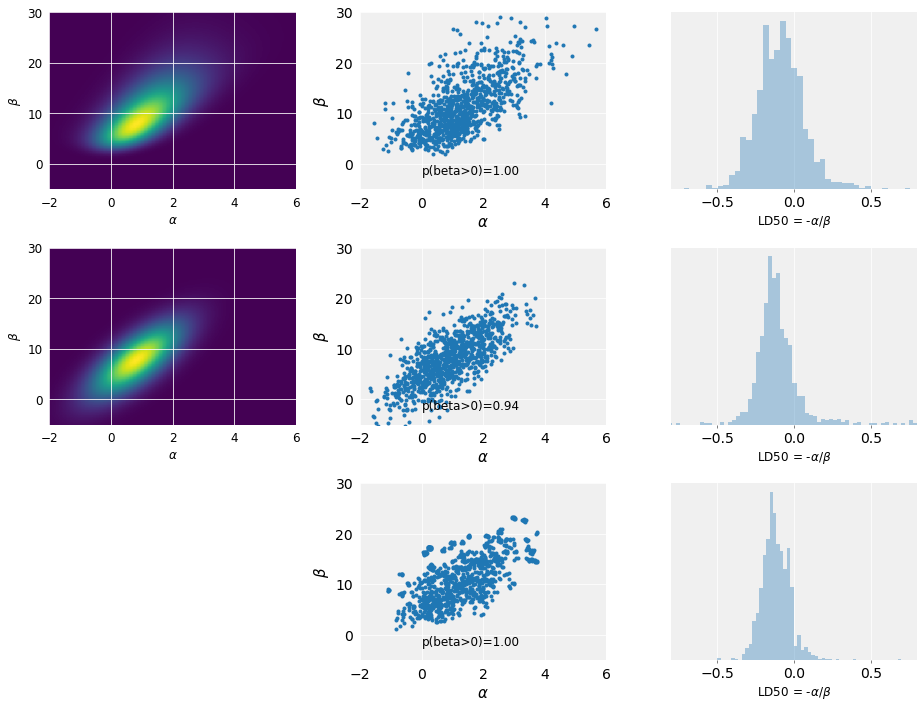

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(13, 10))

# convert samples to InferenceData for plotting
samples = az.convert_to_inference_data({"A": samp_A, "B": samp_B})

samples_norm = az.convert_to_inference_data({"A": samp_norm[:, 0], "B": samp_norm[:, 1]})


rissamples = az.convert_to_inference_data({"A" : rissamp_A, "B" : rissamp_B})

# plot the posterior density
ax = axes[0, 0]
ax.imshow(
    p,
    origin='lower',
    aspect='auto',
    extent=(a[0], a[-1], b[0], b[-1])
)
ax.set_xlim([-2, 6])
ax.set_ylim([-5, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.grid('off')
ax.set_yticks(np.linspace(0, 30, 4))


# plot the samples
ax = axes[0, 1]
az.plot_pair(samples, marginals=False, ax=ax)
ax.set_xlim([-2, 6])
ax.set_ylim([-5, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.text(0, -2, 'p(beta>0)={:.2f}'.format(np.mean(samp_B>0)))
ax.set_yticks(np.linspace(0, 30, 4))


# plot the histogram of LD50
ax = axes[0, 2]
#ax.hist(samp_ld50, np.linspace(-0.8, 0.8, 31))
az.plot_posterior(samp_ld50, kind="hist", point_estimate=None, hdi_prob="hide", ax=ax)
ax.set_xlim([-0.8, 0.8])
ax.set_title("")
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.5, 0.5, 3))

# plot the posterior density for normal approx.
ax = axes[1, 0]
ax.imshow(
    p_norm,
    origin='lower',
    aspect='auto',
    extent=(a[0], a[-1], b[0], b[-1])
)
ax.set_xlim([-2, 6])
ax.set_ylim([-5, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.grid('off')
ax.set_yticks(np.linspace(0, 30, 4))


# plot the samples from the normal approx.
ax = axes[1, 1]
az.plot_pair(samples_norm, marginals=False, ax=ax)
ax.set_xlim([-2, 6])
ax.set_ylim([-5, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_yticks(np.linspace(0, 30, 4))


# Normal approximation does not take into account that the posterior
# is not symmetric and that there is very low density for negative
# beta values. Based on the samples from the normal approximation
# it is estimated that there is about 4% probability that beta is negative!
ax.text(0, -2, 'p(beta>0)={:.2f}'.format(np.mean(samp_norm[:,1]>0)))

# Plot the histogram of LD50
ax = axes[1, 2]
# Since we have strong prior belief that beta should not be negative we can
# improve our normal approximation by conditioning on beta>0.
bpi = samp_norm[:,1] > 0
samp_ld50_norm = - samp_norm[bpi,0] / samp_norm[bpi,1]
az.plot_posterior(samp_ld50_norm, kind="hist", point_estimate=None, hdi_prob="hide", ax=ax)
ax.set_xlim([-0.8, 0.8])
ax.set_title("")
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.5, 0.5, 3))

# plot the samples from the resampling importance sampling
ax = axes[2, 1]
az.plot_pair(rissamples, marginals=False, ax=ax)
ax.set_xlim([-2, 6])
ax.set_ylim([-5, 30])
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_yticks(np.linspace(0, 30, 4))


# Importance sampling is able to improve the estimate of p(beta>0)
ax.text(0, -2, 'p(beta>0)={:.2f}'.format(np.mean(rissamp_B>0)))

# Plot the histogram of LD50
ax = axes[2, 2]
az.plot_posterior(rissamp_ld50, kind="hist", point_estimate=None, hdi_prob="hide", ax=ax)
ax.set_title("")
ax.set_xlim([-0.8, 0.8])
ax.set_xlabel(r'LD50 = -$\alpha/\beta$')
ax.set_yticks(())
ax.set_xticks(np.linspace(-0.5, 0.5, 3))

# hide unused subplot
axes[2, 0].axis('off')

fig.tight_layout()

With normal approximation, It is quite close to real one; 

However, there is problem that $p(\beta \leq0)$ is higher. 

Using Importance sampling, it is remedied a lot. The result distribution is quite close to real one.

# 4. CH11.2. MHsampling with bioassay data

In [135]:
M= 10000 # at least 10000 itesration, told in class
burnin = 1000
#starting value
t1 = 0 ; t2 = 0

tt = np.empty((M, 2))
tt[0] = [t1, t2]

jr = S #use calculated sd for jumping rule


In [136]:
for i in np.arange(M-1):
  now = tt[i]
  now_lp = np.sum(y*(now[0]+now[1]*x)-n*np.log1p(np.exp(now[0]+now[1]*x)))
  jump = np.random.multivariate_normal(now,jr)
  now_jump = np.sum(y*(jump[0]+jump[1]*x)-n*np.log1p(np.exp(jump[0]+jump[1]*x)))
  acceptance = min(1, np.exp(now_jump)/ np.exp(now_lp))
  if np.random.uniform() <acceptance :
    tt[i+1] = jump
  else:
    tt[i+1] = tt[i]



## Graphs

Since I used pre-calculated sd as jumping rule, it converged quick (maybe...)


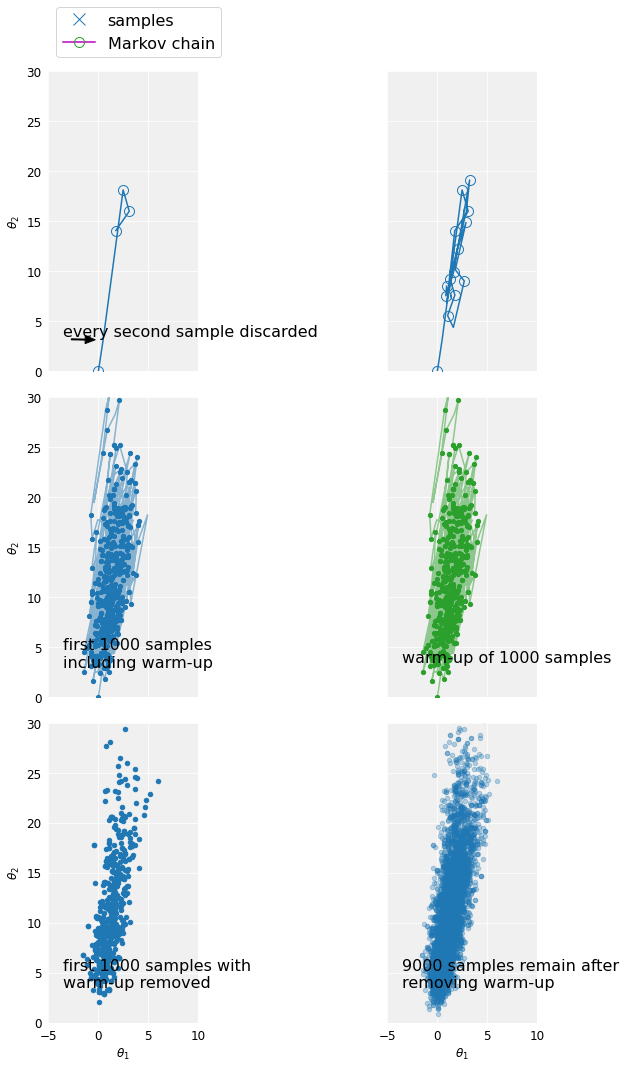

In [139]:
# create the plots
subplotshape = (3, 2)
fig, axes = plt.subplots(
    subplotshape[0], subplotshape[1], sharex=True, sharey=True,
    figsize=(10,15), subplot_kw=dict(aspect='equal')
)

# set limits for axes
axes[0,0].set_xlim([-5, 10])
axes[0,0].set_ylim([0, 30])

# set labels for x- and y-axes
for i in range(subplotshape[0]):
    axes[i,0].set_ylabel(r'$\theta_2$')
for j in range(subplotshape[1]):
    axes[-1,j].set_xlabel(r'$\theta_1$')

# add a shared legend
axes[0,0].legend(
    (  

        mpl.lines.Line2D(
            [], [], linestyle='', marker='x', markersize=12,
            markerfacecolor='none', markeredgecolor='C0'
        ),

        mpl.lines.Line2D(
            [], [], color='m', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C2'
        )
    ),
    (         'samples',
        'Markov chain'
    ),
    numpoints=1,
    loc='lower left',
    bbox_to_anchor=(0., 1.02, 1., .102),
    fontsize=16
)

# ELEVENTH SUBPLOT
ax = axes[0,0]
i = 6
line, = ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0') # plot the line between samples

# plot only every other sample as a circle marker
line, = ax.plot(
    tt[:i+1:2,0], tt[:i+1:2,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0')

#plot arrow marker and text
ax.annotate(
    'every second sample discarded',
    (tt[1,0], tt[1,1]),
    (-3.5, 3.5),
    arrowprops=dict(
        facecolor='black',
        shrink=0.2,
        width=1,
        headwidth=8,
        headlength=10
    ),
    fontsize=16
)

# TWELVTH SUBPLOT
ax = axes[0,1]
i = 26
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0')
ax.plot(
    tt[:i+1:2,0], tt[:i+1:2,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)

# THIRTEENTH SUBPLOT
ax = axes[1,0]
i = 999
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0', alpha=0.5)
ax.scatter(tt[:i+1:2,0], tt[:i+1:2,1], 18, color='C0')
ax.text(-3.5, 3.0, 'first 1000 samples\nincluding warm-up', fontsize=16)

#FOURTEENTH SUBPLOT
ax = axes[1,1]
i = 999
# first 50 warmup samples, to be thrown away
ax.plot(tt[:burnin,0], tt[:burnin,1], color='C2', alpha=0.5)
ax.scatter(tt[:burnin:2,0], tt[:burnin:2,1], 18, color='C2')

ax.text(-3.5, 3.5, 'warm-up of 1000 samples', fontsize=16)

# FIFTEENTH SUBPLOT
# 1000 more samples after warmup
ax = axes[2,0]
i = 1999
ax.scatter(
    tt[burnin:i+1:2,0], tt[burnin:i+1:2,1],
    20, color='C0'
)
ax.text(-3.5, 3.5, 'first 1000 samples with\nwarm-up removed', fontsize=16)

# SIXTEENTH SUBPLOT
ax = axes[2,1]
ax.scatter(
    tt[burnin::2,0], tt[burnin::2,1], 20,
    color='C0', alpha=0.3
)
ax.text(-3.5, 3.5, '9000 samples remain after\nremoving warm-up', fontsize=16)

fig.tight_layout()

## diagnostic

r-hat is too large, but the look fluctuating good and effect diminish by lags. 

Look like it worked properly, checked by graphs. 

In [140]:
indexes = np.arange(burnin, M, 2) # every other index after burnin
samps = tt[indexes] # choose only samples after burnin

samples = az.convert_to_inference_data({r"$\theta$": samps.T})

az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$\theta$,6.479,6.619,-0.894,18.745,3.766,2.965,3.0,53.0,1.8


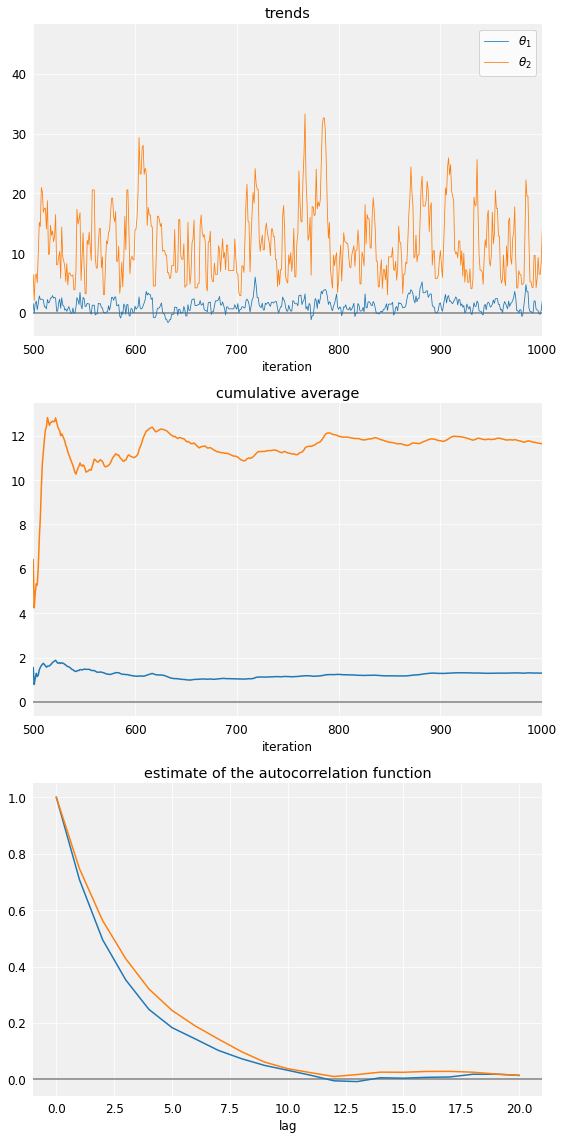

In [142]:
plt.style.use(plot_tools.custom_styles['gray_background'])

fig = plt.figure(figsize=(8, 16))

indexes = np.arange(burnin, M, 2) # every other index after burnin
samps = tt[indexes] # choose only samples after burnin

# Plotting trends for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax1 = fig.add_subplot(3, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(indexes/2, samps, linewidth=0.8) # create lines for both theta1 and theta2 samples
ax1.legend((line1, line2), (r'$\theta_1$', r'$\theta_2$'))
ax1.set_xlabel('iteration')
ax1.set_title('trends')
ax1.set_xlim([burnin/2, 1000])

# Plotting cumulative averages for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax2 = fig.add_subplot(3, 1, 2)
ax2.axhline(y=0, color='gray')
ax2.plot(
    indexes/2,
    np.cumsum(samps, axis=0)/np.arange(1,len(samps)+1)[:,None] # cumulative sum divided by the number of samples
)
ax2.set_xlabel('iteration')
ax2.set_title('cumulative average')
ax2.set_xlim([burnin/2, 1000])

# Plotting estimated autocorrelation for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax3 = fig.add_subplot(3, 1, 3)
maxlag = 20 # maximum lag for autocorrelation
sampsc = samps - np.mean(samps, axis=0) # scale the samples by deducting the mean
acorlags = np.arange(maxlag+1) # lags from 0 to maxlag
ax3.axhline(y=0, color='gray')
# calculate autocorrelation for all different lags
for i in [0,1]: # loop for theta1 and theta2
    t = np.correlate(sampsc[:,i], sampsc[:,i], 'full') # autocorrelation with full range of lags
    t = t[-len(sampsc):-len(sampsc)+maxlag+1] / t[-len(sampsc)] # choose only the lags that we want to use
    ax3.plot(acorlags, t)
ax3.set_xlabel('lag')
ax3.set_title('estimate of the autocorrelation function')

fig.tight_layout()

#5. Gibbs sampling illustration

In [25]:
# edit default plot settings
plt.rc('font', size=12)


###Example1

It use bivariate normal as a model. 

$\left. \begin{bmatrix}  \theta_1 \\ \theta_2  \end{bmatrix} \right| y$ ~ $N \begin{bmatrix} \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}, \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix} \end{bmatrix}$



Therefore, we create a two dimensional distribution to be used as target. 

In [26]:
# parameters 
y1 = 0  # mean of the first dimension
y2 = 0  # mean of the second dimension
rho = 0.8  # covariance 
S = np.array([[1.0, rho], [rho, 1.0]]) # covariance within both dimensions is 1.0, as written above

# starting value of the chain
t1 = -2.5 # first dimension
t2 = 2.5 #second dimension

M = 2*1000 #Iteration number

# 2*1000, becuase one iteration only iterate one parameter

Gibbs sampling procedure is like this:     

we get two conditional dist.

$\theta_1 |\theta_2,y \\ \theta_2|\theta_1,y $

Those two are gotten by property of conditional distribtuion

$\theta_1 |\theta_2,y  \quad \sim \quad N(\mu_1+ \frac{\sigma_{12}}{\sigma_2 ^2 } (\theta_2 - \mu_2) , \sigma_1^2 - \frac{\sigma_{12}^2}{\sigma_2 ^2} ) \\ \theta_2|\theta_1,y \quad \sim \quad N(\mu_2+ \frac{\sigma_{12}}{\sigma_1 ^2 } (\theta_1 - \mu_1) , \sigma_2^2 - \frac{\sigma_{12}^2}{\sigma_1 ^2} )$

Which is equivalent to for this example, 

$\theta_1 |\theta_2,y  \quad \sim \quad N(y_1+ \rho(\theta_2 - y_2) , 1-\rho^2 ) \\ \theta_2|\theta_1,y \quad \sim \quad N(y_2+ \rho(\theta_1 - y_1) , 1-\rho^2 ))$

For gibbas sampling, implement the iteration of,

1. update $\theta_1 ^t |\theta_2^{t-1},y  \quad \sim \quad N(y_1+ \rho(\theta_2^{t-1} - y_2) , 1-\rho^2 ) $
2.update $\theta_2 ^t |\theta_1^{t},y  \quad \sim \quad N(y_2+ \rho(\theta_1^{t} - y_2) , 1-\rho^2 ) $

3. Repeat until sufficient number of samples generate




In [27]:
# Gibbs sampling here

# allocate memory for the samples
tt = np.empty((M, 2))
tt[0] = [t1, t2]    # Save starting point

# load pre-computed values for demonstration
# download at bda3 site

res = np.load('demo11_2.npz')
tt = res['tt']
res.close()
print('loaded pre-computed values in variable `tt`')
print('shape:{}, dtype:{}'.format(tt.shape, tt.dtype))


loaded pre-computed values in variable `tt`
shape:(2001, 2), dtype:float64


Before gibbs sampling, we get 90% HPD. for 2d, it is shaped ellipse

In [28]:
tt# plotting grid
Y1 = np.linspace(-4.5, 4.5, 150)
Y2 = np.linspace(-4.5, 4.5, 150)

# number of samples to discard from the beginning
burnin = 50 * 2 # Using burnin of 100 will actually remove only 50 samples as only one parameter is updated in one basic iteration

# Plot 90% HPD.
# In 2d-case contour for 90% HPD is an ellipse, whose semimajor
# axes can be computed from the eigenvalues of the covariance
# matrix scaled by a value selected to get ellipse match the
# density at the edge of 90% HPD. Angle of the ellipse could be 
# computed from the eigenvectors, but since marginals are same
# we know that angle is 45 degrees.
q = np.sort(np.sqrt(linalg.eigh(S, eigvals_only=True)) * 2.147) # 2.147 is the value to get the ellipse match the 
                                                                # density at the edge of 90% HPD

def add90hpd(ax):
    """Plot 90hpd region into the given axis"""
    el = mpl.patches.Ellipse(
        xy = (y1,y2), #center point of the ellipse
        width = 2 * q[1], # q[1] is larger semimajor axis of the ellipse. Scaling by two gives the larger 
                          # major axis (diameter in the wider direction) 
        height = 2 * q[0], # q[0] is smaller semimajor axis of the ellipse. Scaling by two gives the smaller 
                           # major axis (diameter in the narrower direction) 
        angle = 45, #angle of the ellipse is 45 degrees (pi/4) as mentioned earlier
        facecolor = 'none',
        edgecolor = 'C1'
    )
    ax.add_artist(el)

Next is the illustration of gibbs sampling. based on pre-computed values, it show how it generates samples

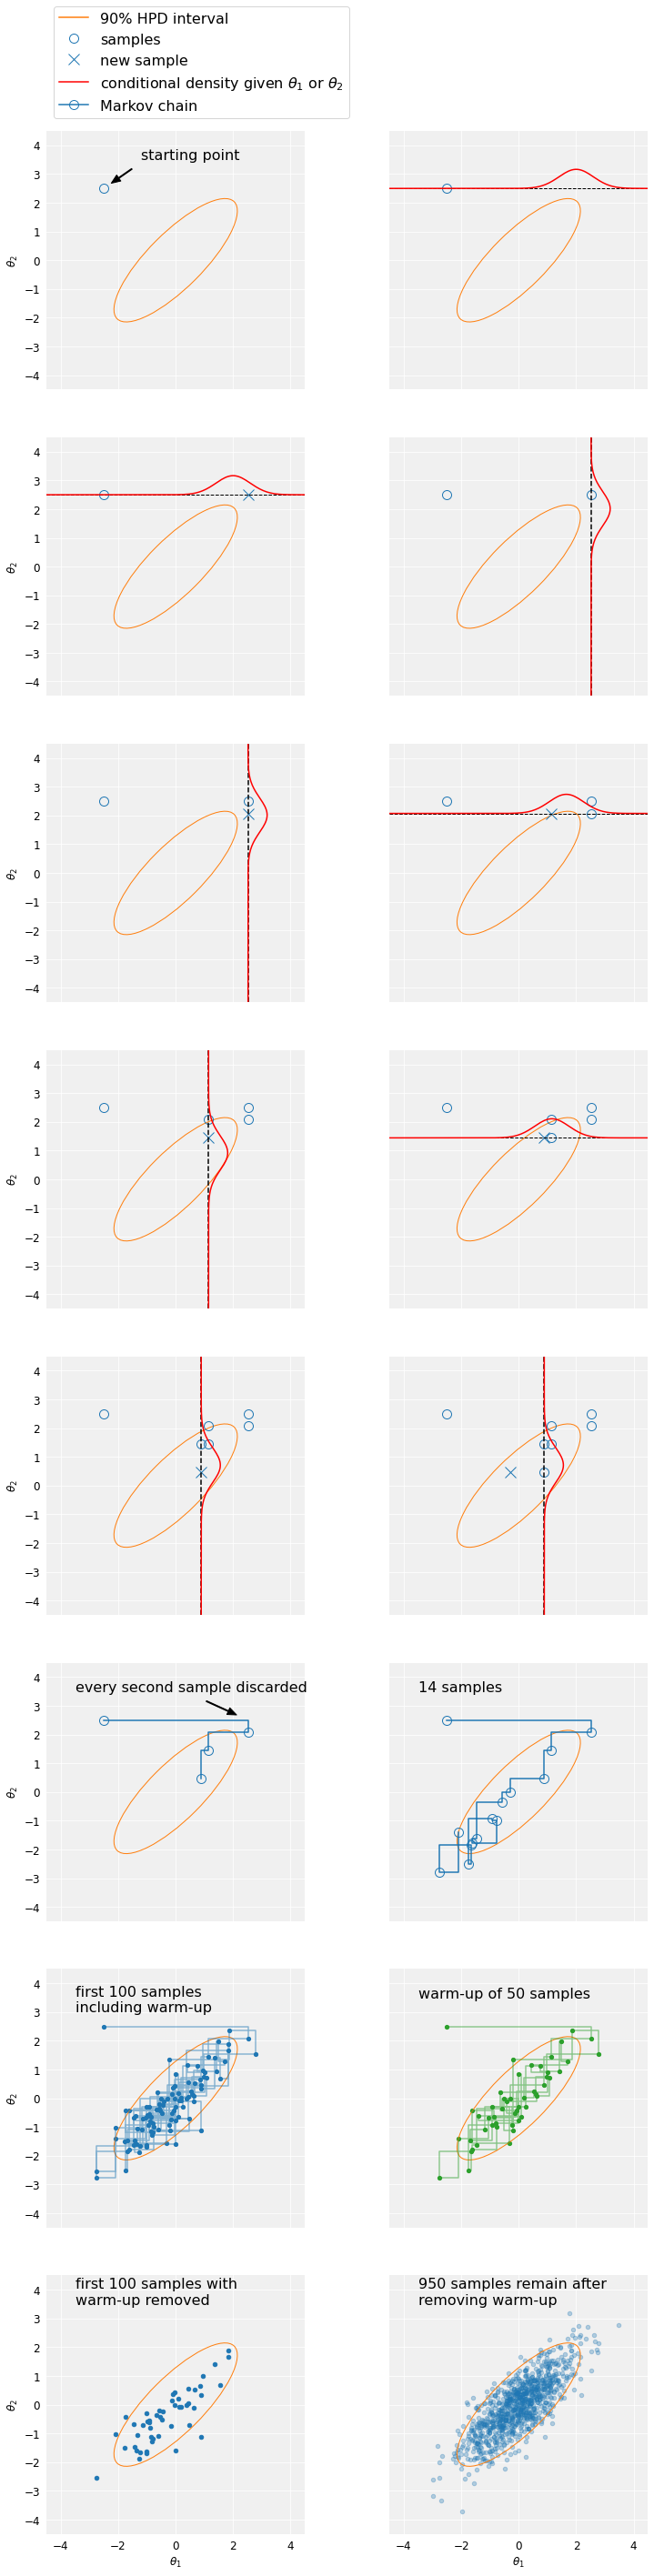

In [29]:
# create the plots
subplotshape = (8, 2)
fig, axes = plt.subplots(
    subplotshape[0], subplotshape[1], sharex=True, sharey=True,
    figsize=(10,40), subplot_kw=dict(aspect='equal')
)

# set limits for axes
axes[0,0].set_xlim([-4.5, 4.5])
axes[0,0].set_ylim([-4.5, 4.5])

# set labels for x- and y-axes
for i in range(subplotshape[0]):
    axes[i,0].set_ylabel(r'$\theta_2$')
for j in range(subplotshape[1]):
    axes[-1,j].set_xlabel(r'$\theta_1$')

# add a shared legend
axes[0,0].legend(
    (   mpl.lines.Line2D([], [], color='C1'), 
        mpl.lines.Line2D(
            [], [], linestyle='', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], linestyle='', marker='x', markersize=12,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D([], [], color='r'),
        mpl.lines.Line2D(
            [], [], color='C0', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], color='m', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C2'
        )
    ),
    (   '90% HPD interval',
        'samples',
        'new sample',
        r'conditional density given $\theta_{1}$ or $\theta_{2}$',
        'Markov chain'
    ),
    numpoints=1,
    loc='lower left',
    bbox_to_anchor=(0., 1.02, 1., .102),
    fontsize=16
)

# FIRST SUBPLOT
ax = axes[0,0] 
add90hpd(ax) #drawing 90% HPD

#start point
ax.plot(
    tt[0,0], tt[0,1], 'o', markersize=10,  
    markerfacecolor='none', markeredgecolor='C0'
)

#start point highlighting arrow
ax.annotate(          
    'starting point',
    (tt[0,0], tt[0,1]),
    (-1.2, 3.5),
    arrowprops=dict(
        facecolor='black',
        shrink=0.2,
        width=1,
        headwidth=8,
        headlength=10
    ),
    fontsize=16
)

# SECOND SUBPLOT
ax = axes[0,1] 
add90hpd(ax)

# plot the older samples
i = 0 #indexes
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1) 

# plotting the conditional density given  theta2
# same mathmatical procedure written above
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + rho*(tt[i,1] - y2),
        scale = np.sqrt((1 - rho**2))
    ),
    color = 'r'
)

# THIRD SUBPLOT
ax = axes[1,0]
add90hpd(ax)
i = 0 
# plot the older samples
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
# plot the next new sample, pre-generated
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1) 

# plotting the conditional density given theta1 
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + rho*(tt[i,1] - y2),
        scale = np.sqrt((1 - rho**2))
    ),
    color = 'r'
)

# Until 10th subplot, it is just repetition of same procedure
# FOURTH SUBPLOT
ax = axes[1,1]
add90hpd(ax)
i = 1 
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + rho*(tt[i,0] - y1),
        scale = np.sqrt((1 - rho**2))
    ),
    Y2,
    color = 'r'
)

# FIFTH SUBPLOT
ax = axes[2,0]
add90hpd(ax)
i = 1
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + rho*(tt[i,0] - y1),
        scale = np.sqrt((1 - rho**2))
    ),
    Y2,
    color = 'r'
)

# SIXTH SUBPLOT
ax = axes[2,1]
add90hpd(ax)
i = 2
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1)
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + rho*(tt[i,1] - y2),
        scale = np.sqrt((1 - rho**2))
    ),
    color = 'r'
)

# SEVENTH SUBPLOT
ax = axes[3,0]
add90hpd(ax)
i = 3
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + rho*(tt[i,0] - y1),
        scale = np.sqrt((1 - rho**2))
    ),
    Y2,
    color = 'r'
)

# EIGHTH SUBPLOT
ax = axes[3,1]
add90hpd(ax)
i = 4
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1)
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + rho*(tt[i,1] - y2),
        scale = np.sqrt((1 - rho**2))
    ),
    color = 'r'
)

#NINTH SUBPLOT
ax = axes[4,0]
add90hpd(ax)
i = 5
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + rho*(tt[i,0] - y1),
        scale = np.sqrt((1 - rho**2))
    ),
    Y2,
    color = 'r'
)

#TENTH SUBPLOT
ax = axes[4,1]
add90hpd(ax)
i = 6
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + rho*(tt[i,0] - y1),
        scale = np.sqrt((1 - rho**2))
    ),
    Y2,
    color = 'r'
)

# ELEVENTH SUBPLOT
ax = axes[5,0]
add90hpd(ax)
i = 6
line, = ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0') # plot the line between samples

# plot only every other sample as a circle marker
line, = ax.plot(
    tt[:i+1:2,0], tt[:i+1:2,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0')

#plot arrow marker and text
ax.annotate(
    'every second sample discarded',
    (tt[1,0], tt[1,1]),
    (-3.5, 3.5),
    arrowprops=dict(
        facecolor='black',
        shrink=0.2,
        width=1,
        headwidth=8,
        headlength=10
    ),
    fontsize=16
)

# TWELVTH SUBPLOT
ax = axes[5,1]
add90hpd(ax)
i = 26
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0')
ax.plot(
    tt[:i+1:2,0], tt[:i+1:2,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.text(-3.5, 3.5, '14 samples', fontsize=16)

# THIRTEENTH SUBPLOT
ax = axes[6,0]
add90hpd(ax)
i = 198
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0', alpha=0.5)
ax.scatter(tt[:i+1:2,0], tt[:i+1:2,1], 18, color='C0')
ax.text(-3.5, 3.0, 'first 100 samples\nincluding warm-up', fontsize=16)

#FOURTEENTH SUBPLOT
ax = axes[6,1]
add90hpd(ax)
i = 198
# first 50 warmup samples, to be thrown away
ax.plot(tt[:burnin,0], tt[:burnin,1], color='C2', alpha=0.5)
ax.scatter(tt[:burnin:2,0], tt[:burnin:2,1], 18, color='C2')

ax.text(-3.5, 3.5, 'warm-up of 50 samples', fontsize=16)

# FIFTEENTH SUBPLOT
# 100 more samples after warmup
ax = axes[7,0]
add90hpd(ax)
i = 198
ax.scatter(
    tt[burnin:i+1:2,0], tt[burnin:i+1:2,1],
    20, color='C0'
)
ax.text(-3.5, 3.5, 'first 100 samples with\nwarm-up removed', fontsize=16)

# SIXTEENTH SUBPLOT
ax = axes[7,1]
add90hpd(ax)
ax.scatter(
    tt[burnin::2,0], tt[burnin::2,1], 20,
    color='C0', alpha=0.3
)
ax.text(-3.5, 3.5, '950 samples remain after\nremoving warm-up', fontsize=16)

fig.tight_layout()


I skip the animation procedure here.

###Convergence diagnostics

I diplay some diagnostics such as the $\hat{R}$ and ESS for $\theta$ with the arviz library, as done in site. Notice that $\hat{R} < 1.1$ which is an indication that the chains have mixed.

* r hat is diagnostic for how convergence happened well. If it is lower than some point(usually 1.1), it is said mixed well. 

In [30]:
# points located in burn-in is not need, so get only indexes for after burn-in
indexes = np.arange(burnin, M, 2) 
samps = tt[indexes] 

samples = az.convert_to_inference_data({r"$\theta$": samps.T})

az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$\theta$,-0.036,0.976,-1.974,1.712,0.043,0.03,519.0,870.0,1.01


###Visual convergence diagnostics

One can see that for each iteration, parameter moves quickly randomly, which means sampling is working properly. About lags, it is around 0.8 with one lag, and comes down to 0 quickly, which means mc works properly, too

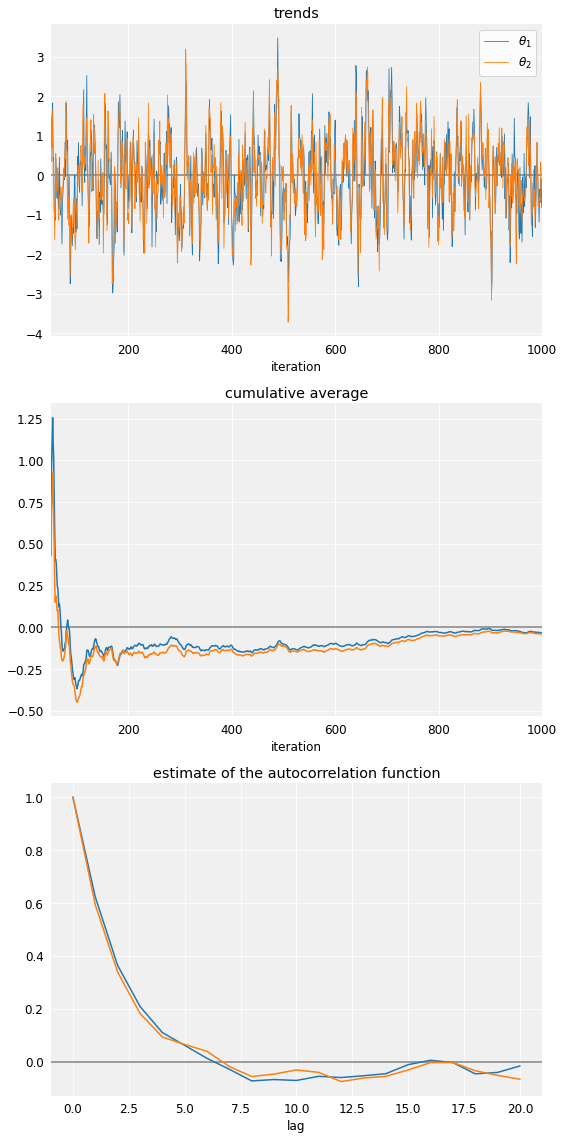

In [31]:
plt.style.use(plot_tools.custom_styles['gray_background'])

fig = plt.figure(figsize=(8, 16))

# Plotting trends for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax1 = fig.add_subplot(3, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(indexes/2, samps, linewidth=0.8) # create lines for both theta1 and theta2 samples
ax1.legend((line1, line2), (r'$\theta_1$', r'$\theta_2$'))
ax1.set_xlabel('iteration')
ax1.set_title('trends')
ax1.set_xlim([burnin/2, 1000])

# Plotting cumulative averages for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax2 = fig.add_subplot(3, 1, 2)
ax2.axhline(y=0, color='gray')
ax2.plot(
    indexes/2,
    np.cumsum(samps, axis=0)/np.arange(1,len(samps)+1)[:,None] # cumulative sum divided by the number of samples
)
ax2.set_xlabel('iteration')
ax2.set_title('cumulative average')
ax2.set_xlim([burnin/2, 1000])

# Plotting estimated autocorrelation for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax3 = fig.add_subplot(3, 1, 3)
maxlag = 20 # maximum lag for autocorrelation
sampsc = samps - np.mean(samps, axis=0) # scale the samples by deducting the mean
acorlags = np.arange(maxlag+1) # lags from 0 to maxlag
ax3.axhline(y=0, color='gray')
# calculate autocorrelation for all different lags
for i in [0,1]: # loop for theta1 and theta2
    t = np.correlate(sampsc[:,i], sampsc[:,i], 'full') # autocorrelation with full range of lags
    t = t[-len(sampsc):-len(sampsc)+maxlag+1] / t[-len(sampsc)] # choose only the lags that we want to use
    ax3.plot(acorlags, t)
ax3.set_xlabel('lag')
ax3.set_title('estimate of the autocorrelation function')

fig.tight_layout()

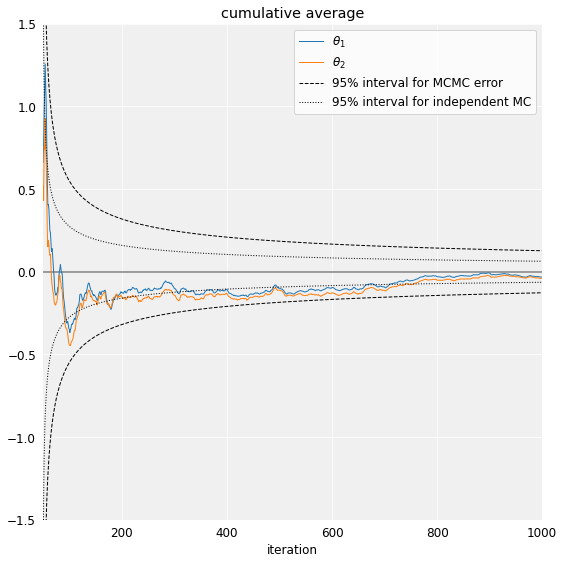

In [32]:
fig = plt.figure(figsize=(8, 8))

indexes = np.arange(burnin, M, 2)
samps = tt[indexes]
nsamps = np.arange(1, len(samps)+1)

# Plotting cumulative averages for theta1 and theta2 behavior separately similarly as earlier.
ax1 = fig.add_subplot(1, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(
    indexes/2,
    np.cumsum(samps, axis=0) / nsamps[:,None],
    linewidth=1
)

# Plotting 95% interval for MCMC error
er1, = ax1.plot(
    indexes/2, 1.96/np.sqrt(nsamps/4), 'k--', linewidth=1)
ax1.plot(indexes/2, -1.96/np.sqrt(nsamps/4), 'k--', linewidth=1)

# Plotting 95% interval for independent MC
er2, = ax1.plot(
    indexes/2, 1.96/np.sqrt(nsamps), 'k:', linewidth=1)
ax1.plot(indexes/2, -1.96/np.sqrt(nsamps), 'k:', linewidth=1)

# axis label and title
ax1.set_xlabel('iteration')
ax1.set_title('cumulative average')

# Plotting legend
ax1.legend(
    (line1, line2, er1, er2),
    (r'$\theta_1$', r'$\theta_2$',
      '95% interval for MCMC error',
      '95% interval for independent MC'
    )
)
ax1.set_xlim([burnin/2, 1000])
ax1.set_ylim([-1.5, 1.5])

fig.tight_layout()

## Example 2

same works for $\rho$ = 0.99

In [33]:
# Gibbs sampling here
rho = 0.99
S = np.array([[1.0, rho], [rho, 1.0]])
# allocate memory for the samples
tt = np.empty((M, 2))
tt[0] = [t1, t2]    # Save starting point

# load pre-computed values for demonstration
# download at bda3 site

res = np.loadtxt('demo11_1b.csv', skiprows=1, usecols = (1,2), delimiter = ',')
tt = res
print('loaded pre-computed values in variable `tt`')
print('shape:{}, dtype:{}'.format(tt.shape, tt.dtype))

q = np.sort(np.sqrt(linalg.eigh(S, eigvals_only=True)) * 2.147)

loaded pre-computed values in variable `tt`
shape:(2001, 2), dtype:float64


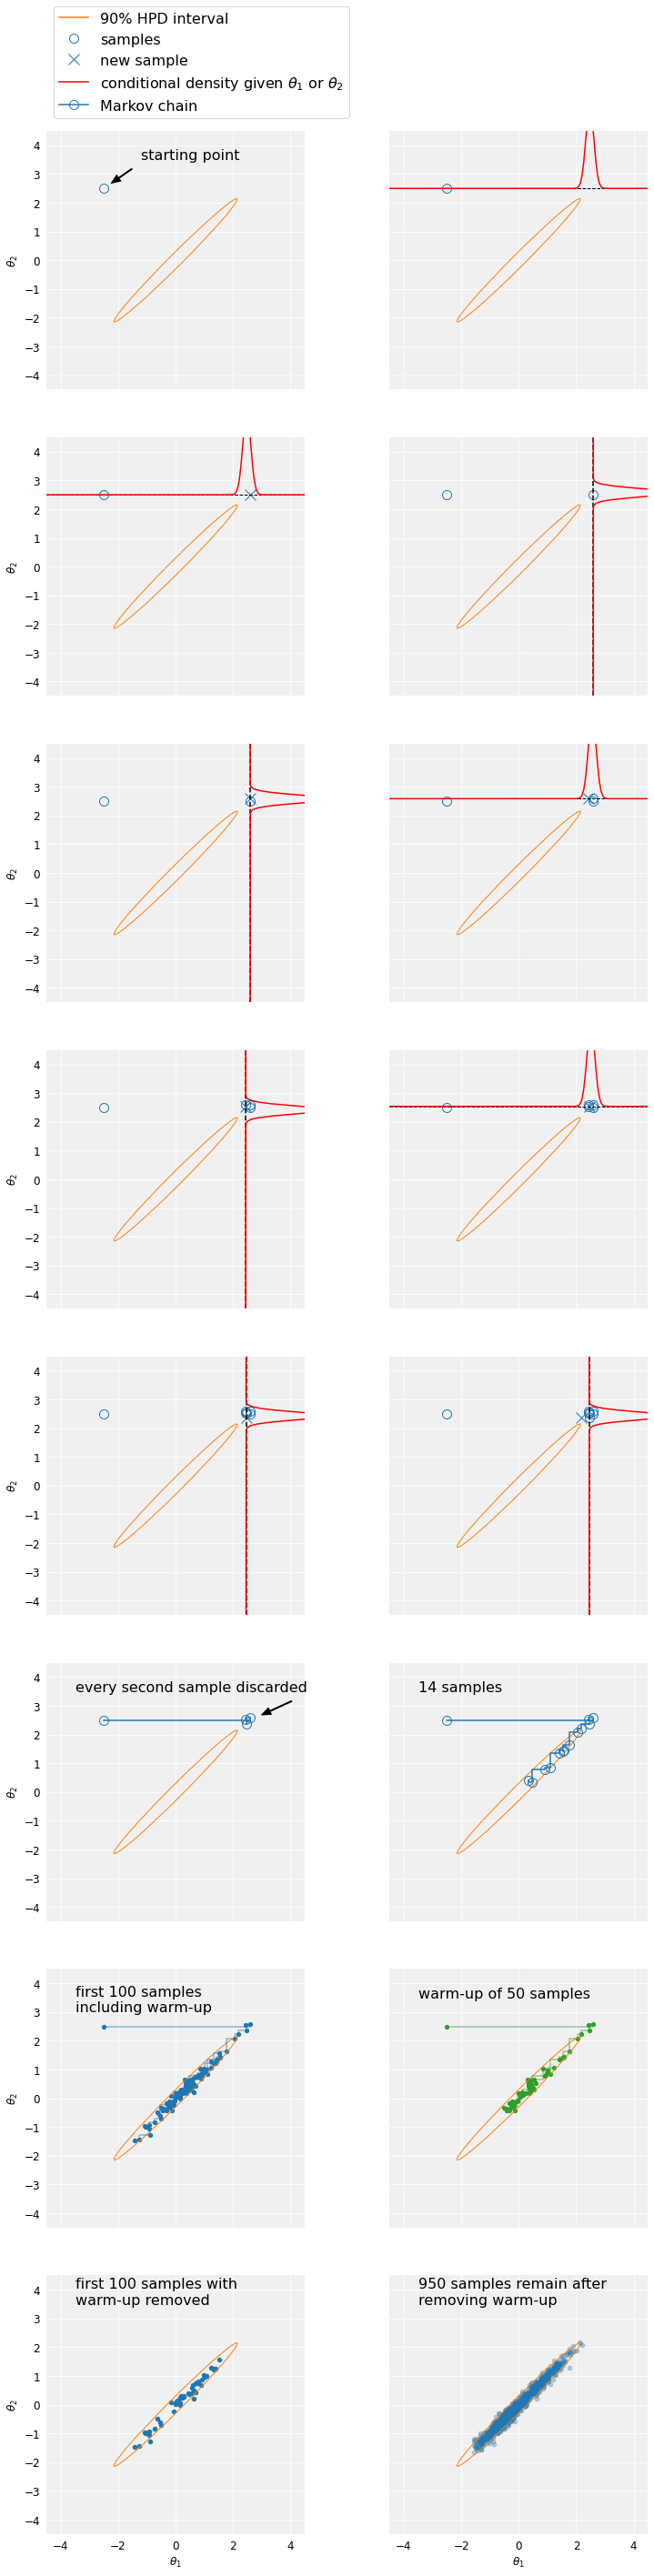

In [34]:
# create the plots
subplotshape = (8, 2)
fig, axes = plt.subplots(
    subplotshape[0], subplotshape[1], sharex=True, sharey=True,
    figsize=(10,40), subplot_kw=dict(aspect='equal')
)

# set limits for axes
axes[0,0].set_xlim([-4.5, 4.5])
axes[0,0].set_ylim([-4.5, 4.5])

# set labels for x- and y-axes
for i in range(subplotshape[0]):
    axes[i,0].set_ylabel(r'$\theta_2$')
for j in range(subplotshape[1]):
    axes[-1,j].set_xlabel(r'$\theta_1$')

# add a shared legend
axes[0,0].legend(
    (   mpl.lines.Line2D([], [], color='C1'), 
        mpl.lines.Line2D(
            [], [], linestyle='', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], linestyle='', marker='x', markersize=12,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D([], [], color='r'),
        mpl.lines.Line2D(
            [], [], color='C0', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], color='m', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C2'
        )
    ),
    (   '90% HPD interval',
        'samples',
        'new sample',
        r'conditional density given $\theta_{1}$ or $\theta_{2}$',
        'Markov chain'
    ),
    numpoints=1,
    loc='lower left',
    bbox_to_anchor=(0., 1.02, 1., .102),
    fontsize=16
)

# FIRST SUBPLOT
ax = axes[0,0] 
add90hpd(ax) #drawing 90% HPD

#start point
ax.plot(
    tt[0,0], tt[0,1], 'o', markersize=10,  
    markerfacecolor='none', markeredgecolor='C0'
)

#start point highlighting arrow
ax.annotate(          
    'starting point',
    (tt[0,0], tt[0,1]),
    (-1.2, 3.5),
    arrowprops=dict(
        facecolor='black',
        shrink=0.2,
        width=1,
        headwidth=8,
        headlength=10
    ),
    fontsize=16
)

# SECOND SUBPLOT
ax = axes[0,1] 
add90hpd(ax)

# plot the older samples
i = 0 #indexes
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1) 

# plotting the conditional density given  theta2
# same mathmatical procedure written above
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + rho*(tt[i,1] - y2),
        scale = np.sqrt((1 - rho**2))
    ),
    color = 'r'
)

# THIRD SUBPLOT
ax = axes[1,0]
add90hpd(ax)
i = 0 
# plot the older samples
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
# plot the next new sample, pre-generated
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1) 

# plotting the conditional density given theta1 
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + rho*(tt[i,1] - y2),
        scale = np.sqrt((1 - rho**2))
    ),
    color = 'r'
)

# Until 10th subplot, it is just repetition of same procedure
# FOURTH SUBPLOT
ax = axes[1,1]
add90hpd(ax)
i = 1 
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + rho*(tt[i,0] - y1),
        scale = np.sqrt((1 - rho**2))
    ),
    Y2,
    color = 'r'
)

# FIFTH SUBPLOT
ax = axes[2,0]
add90hpd(ax)
i = 1
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + rho*(tt[i,0] - y1),
        scale = np.sqrt((1 - rho**2))
    ),
    Y2,
    color = 'r'
)

# SIXTH SUBPLOT
ax = axes[2,1]
add90hpd(ax)
i = 2
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1)
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + rho*(tt[i,1] - y2),
        scale = np.sqrt((1 - rho**2))
    ),
    color = 'r'
)

# SEVENTH SUBPLOT
ax = axes[3,0]
add90hpd(ax)
i = 3
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + rho*(tt[i,0] - y1),
        scale = np.sqrt((1 - rho**2))
    ),
    Y2,
    color = 'r'
)

# EIGHTH SUBPLOT
ax = axes[3,1]
add90hpd(ax)
i = 4
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axhline(y=tt[i,1], linestyle='--', color='k', linewidth=1)
ax.plot(
    Y1,
    tt[i,1] + stats.norm.pdf(
        Y1,
        loc = y1 + rho*(tt[i,1] - y2),
        scale = np.sqrt((1 - rho**2))
    ),
    color = 'r'
)

#NINTH SUBPLOT
ax = axes[4,0]
add90hpd(ax)
i = 5
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + rho*(tt[i,0] - y1),
        scale = np.sqrt((1 - rho**2))
    ),
    Y2,
    color = 'r'
)

#TENTH SUBPLOT
ax = axes[4,1]
add90hpd(ax)
i = 6
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.plot(
    tt[i+1,0], tt[i+1,1], 'x', markersize=12,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.axvline(x=tt[i,0], linestyle='--', color='k')
ax.plot(
    tt[i,0] + stats.norm.pdf(
        Y2,
        loc = y2 + rho*(tt[i,0] - y1),
        scale = np.sqrt((1 - rho**2))
    ),
    Y2,
    color = 'r'
)

# ELEVENTH SUBPLOT
ax = axes[5,0]
add90hpd(ax)
i = 6
line, = ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0') # plot the line between samples

# plot only every other sample as a circle marker
line, = ax.plot(
    tt[:i+1:2,0], tt[:i+1:2,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0')

#plot arrow marker and text
ax.annotate(
    'every second sample discarded',
    (tt[1,0], tt[1,1]),
    (-3.5, 3.5),
    arrowprops=dict(
        facecolor='black',
        shrink=0.2,
        width=1,
        headwidth=8,
        headlength=10
    ),
    fontsize=16
)

# TWELVTH SUBPLOT
ax = axes[5,1]
add90hpd(ax)
i = 26
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0')
ax.plot(
    tt[:i+1:2,0], tt[:i+1:2,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.text(-3.5, 3.5, '14 samples', fontsize=16)

# THIRTEENTH SUBPLOT
ax = axes[6,0]
add90hpd(ax)
i = 198
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0', alpha=0.5)
ax.scatter(tt[:i+1:2,0], tt[:i+1:2,1], 18, color='C0')
ax.text(-3.5, 3.0, 'first 100 samples\nincluding warm-up', fontsize=16)

#FOURTEENTH SUBPLOT
ax = axes[6,1]
add90hpd(ax)
i = 198
# first 50 warmup samples, to be thrown away
ax.plot(tt[:burnin,0], tt[:burnin,1], color='C2', alpha=0.5)
ax.scatter(tt[:burnin:2,0], tt[:burnin:2,1], 18, color='C2')

ax.text(-3.5, 3.5, 'warm-up of 50 samples', fontsize=16)

# FIFTEENTH SUBPLOT
# 100 more samples after warmup
ax = axes[7,0]
add90hpd(ax)
i = 198
ax.scatter(
    tt[burnin:i+1:2,0], tt[burnin:i+1:2,1],
    20, color='C0'
)
ax.text(-3.5, 3.5, 'first 100 samples with\nwarm-up removed', fontsize=16)

# SIXTEENTH SUBPLOT
ax = axes[7,1]
add90hpd(ax)
ax.scatter(
    tt[burnin::2,0], tt[burnin::2,1], 20,
    color='C0', alpha=0.3
)
ax.text(-3.5, 3.5, '950 samples remain after\nremoving warm-up', fontsize=16)

fig.tight_layout()

### Convergence diagonostics

R-hat larger than 1.1, which means bad convergence

In [35]:
indexes = np.arange(burnin, M, 2) # every other index after burnin
samps = tt[indexes] # choose only samples after burnin

samples = az.convert_to_inference_data({r"$\theta$": samps.T})

az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$\theta$,-0.088,0.772,-1.369,1.39,0.228,0.166,11.0,67.0,1.17


### Visual diagnostics

For iterations, thetas dont fluctuate randomly. We cannot say that convergence worked properly

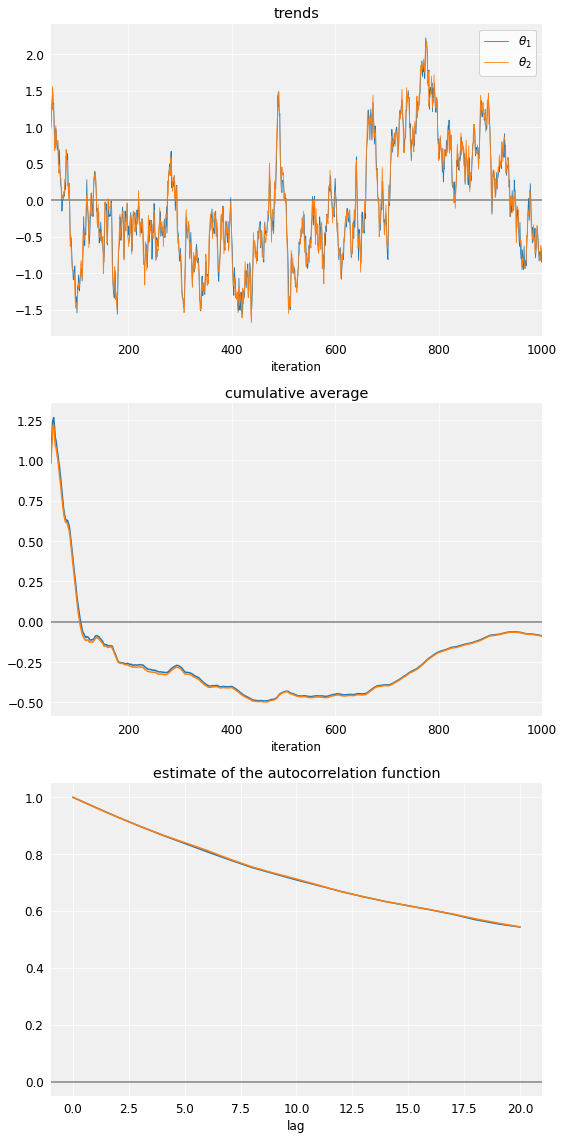

In [36]:
plt.style.use(plot_tools.custom_styles['gray_background'])

fig = plt.figure(figsize=(8, 16))

indexes = np.arange(burnin, M, 2) # every other index after burnin
samps = tt[indexes] # choose only samples after burnin

# Plotting trends for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax1 = fig.add_subplot(3, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(indexes/2, samps, linewidth=0.8) # create lines for both theta1 and theta2 samples
ax1.legend((line1, line2), (r'$\theta_1$', r'$\theta_2$'))
ax1.set_xlabel('iteration')
ax1.set_title('trends')
ax1.set_xlim([burnin/2, 1000])

# Plotting cumulative averages for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax2 = fig.add_subplot(3, 1, 2)
ax2.axhline(y=0, color='gray')
ax2.plot(
    indexes/2,
    np.cumsum(samps, axis=0)/np.arange(1,len(samps)+1)[:,None] # cumulative sum divided by the number of samples
)
ax2.set_xlabel('iteration')
ax2.set_title('cumulative average')
ax2.set_xlim([burnin/2, 1000])

# Plotting estimated autocorrelation for theta1 and theta2 behavior separately. Only 950 samples after warm-up included.
ax3 = fig.add_subplot(3, 1, 3)
maxlag = 20 # maximum lag for autocorrelation
sampsc = samps - np.mean(samps, axis=0) # scale the samples by deducting the mean
acorlags = np.arange(maxlag+1) # lags from 0 to maxlag
ax3.axhline(y=0, color='gray')
# calculate autocorrelation for all different lags
for i in [0,1]: # loop for theta1 and theta2
    t = np.correlate(sampsc[:,i], sampsc[:,i], 'full') # autocorrelation with full range of lags
    t = t[-len(sampsc):-len(sampsc)+maxlag+1] / t[-len(sampsc)] # choose only the lags that we want to use
    ax3.plot(acorlags, t)
ax3.set_xlabel('lag')
ax3.set_title('estimate of the autocorrelation function')

fig.tight_layout()

# 6. Metropolis sampling + convergence 1

As I understood, this is the example 1 of :https://github.com/avehtari/BDA_py_demos/blob/master/demos_ch11/demo11_2.ipynb

In [37]:
# parameters 
y1 = 0  # mean of the first dimension
y2 = 0  # mean of the second dimension
rho = 0.8  # covariance 
S = np.array([[1.0, rho], [rho, 1.0]]) # covariance within both dimensions is 1.0, as written above

# starting value of the chain
t1 = -2.5 # first dimension
t2 = 2.5 #second dimension

M = 5000 #Iteration number. It does not multiply 2, because we don't iterate for each parameter

# Gibbs sampling here

# allocate memory for the samples
tt = np.empty((M, 2))
tt[0] = [t1, t2]    # Save starting point

# load pre-computed values for demonstration
# download at bda3 site

res = np.loadtxt('demo11_2a.csv', skiprows=1, usecols = (1,2), delimiter = ',')
tt = res
print('loaded pre-computed values in variable `tt`')
print('shape:{}, dtype:{}'.format(tt.shape, tt.dtype))


loaded pre-computed values in variable `tt`
shape:(5000, 2), dtype:float64


Next is same procedure with question 5, with litte difference like burn-in

In [38]:
tt# plotting grid
Y1 = np.linspace(-4.5, 4.5, 150)
Y2 = np.linspace(-4.5, 4.5, 150)

burnin = 500
q = np.sort(np.sqrt(linalg.eigh(S, eigvals_only=True)) * 2.147) 

def add90hpd(ax):
    """Plot 90hpd region into the given axis"""
    el = mpl.patches.Ellipse(
        xy = (y1,y2), #center point of the ellipse
        width = 2 * q[1], # q[1] is larger semimajor axis of the ellipse. Scaling by two gives the larger 
                          # major axis (diameter in the wider direction) 
        height = 2 * q[0], # q[0] is smaller semimajor axis of the ellipse. Scaling by two gives the smaller 
                           # major axis (diameter in the narrower direction) 
        angle = 45, #angle of the ellipse is 45 degrees (pi/4) as mentioned earlier
        facecolor = 'none',
        edgecolor = 'C1'
    )
    ax.add_artist(el)

The next graphs show how the process works, comparing before and after removal of burn-in periods


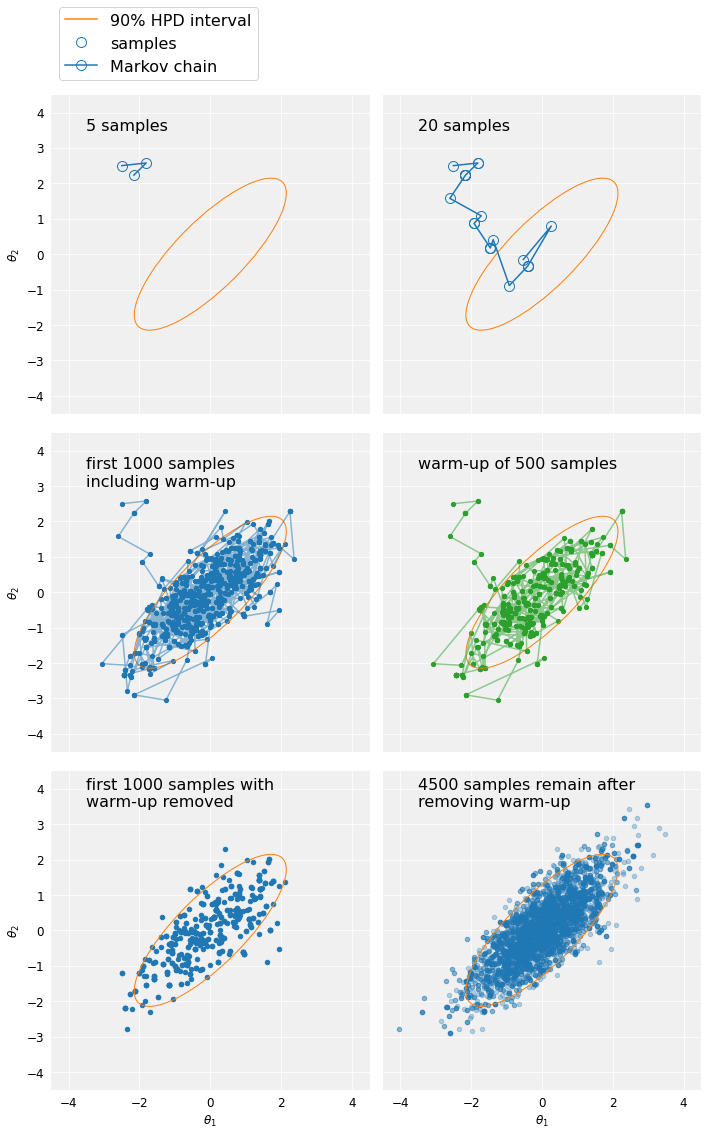

In [39]:
# create the plots
subplotshape = (3, 2)
fig, axes = plt.subplots(
    subplotshape[0], subplotshape[1], sharex=True, sharey=True,
    figsize=(10,16), subplot_kw=dict(aspect='equal')
)

# set limits for axes
axes[0,0].set_xlim([-4.5, 4.5])
axes[0,0].set_ylim([-4.5, 4.5])

# set labels for x- and y-axes
for i in range(subplotshape[0]):
    axes[i,0].set_ylabel(r'$\theta_2$')
for j in range(subplotshape[1]):
    axes[-1,j].set_xlabel(r'$\theta_1$')

# add a shared legend
axes[0,0].legend(
    (   mpl.lines.Line2D([], [], color='C1'), 
        mpl.lines.Line2D(
            [], [], linestyle='', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], color='C0', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], color='m', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C2'
        )
    ),
    (   '90% HPD interval',
        'samples',
        'Markov chain'
    ),
    numpoints=1,
    loc='lower left',
    bbox_to_anchor=(0., 1.02, 1., .102),
    fontsize=16
)


# FIRST SUBPLOT
ax = axes[0,0]
add90hpd(ax)
i = 5
line, = ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0') # plot the line between samples

# plot only every other sample as a circle marker
line, = ax.plot(
    tt[:i+1:2,0], tt[:i+1:2,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0')
ax.text(-3.5, 3.5, '5 samples', fontsize=16)

# SECOND SUBPLOT
ax = axes[0,1]
add90hpd(ax)
i = 20
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0')
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.text(-3.5, 3.5, '20 samples', fontsize=16)

# THIRD SUBPLOT
ax = axes[1,0]
add90hpd(ax)
i = 1000
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0', alpha=0.5)
ax.scatter(tt[:i+1,0], tt[:i+1,1], 18, color='C0')
ax.text(-3.5, 3.0, 'first 1000 samples\nincluding warm-up', fontsize=16)

#FOURTH SUBPLOT
ax = axes[1,1]
add90hpd(ax)
# plotting warm-up
ax.plot(tt[:burnin,0], tt[:burnin,1], color='C2', alpha=0.5)
ax.scatter(tt[:burnin,0], tt[:burnin,1], 18, color='C2')

ax.text(-3.5, 3.5, 'warm-up of 500 samples', fontsize=16)

# FIFTH SUBPLOT
ax = axes[2,0]
add90hpd(ax)
i = 999
ax.scatter(
    tt[burnin:i+1,0], tt[burnin:i+1,1],
    20, color='C0'
)
ax.text(-3.5, 3.5, 'first 1000 samples with\nwarm-up removed', fontsize=16)

# SIXTH SUBPLOT
ax = axes[2,1]
add90hpd(ax)
ax.scatter(
    tt[burnin:,0], tt[burnin:,1], 20,
    color='C0', alpha=0.3
)
ax.text(-3.5, 3.5, '4500 samples remain after\nremoving warm-up', fontsize=16)

fig.tight_layout()

We can see that for the final graph, aroud 90% of points are located in 90% HPD,

Meaning it works properly.

The difference with gibbs- sampling could be seen that from the first graph, 

although 5 points are simulated, only 5 are shown, which menas 2 are rejected.

### Convergence Diagonostics

Showing good R-hat(<1.1)


In [40]:
indexes = np.arange(burnin, M, 2) # every other index after burnin
samps = tt[indexes] # choose only samples after burnin

samples = az.convert_to_inference_data({r"$\theta$": samps.T})

az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$\theta$,-0.006,0.968,-1.735,1.914,0.048,0.034,414.0,586.0,1.01


###  Visual convergence diagnostics

All graphs show good results : randomly fluctuating trend, summing up to 0, diminishing effect by lags

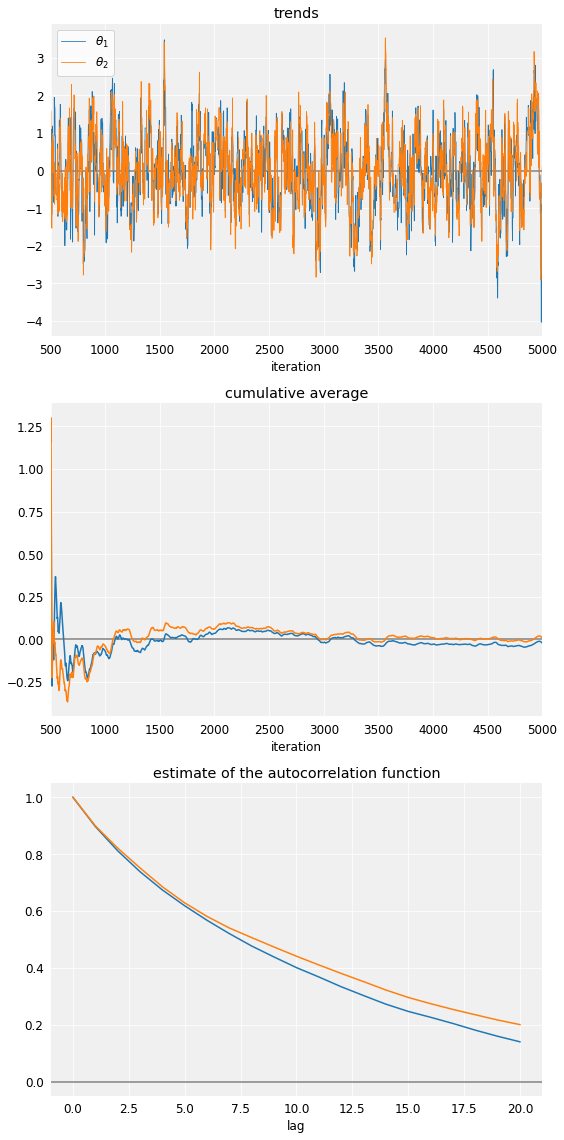

In [41]:
plt.style.use(plot_tools.custom_styles['gray_background'])

fig = plt.figure(figsize=(8, 16))

indexes = np.arange(burnin, M)
samps = tt[indexes] # choose only samples after burnin

# Plotting trends for theta1 and theta2 behavior separately. Only 4500 samples after warm-up included.
ax1 = fig.add_subplot(3, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(indexes, samps, linewidth=0.8) # create lines for both theta1 and theta2 samples
ax1.legend((line1, line2), (r'$\theta_1$', r'$\theta_2$'))
ax1.set_xlabel('iteration')
ax1.set_title('trends')
ax1.set_xlim([burnin, 5000])

# Plotting cumulative averages for theta1 and theta2 behavior separately. Only 4500 samples after warm-up included.
ax2 = fig.add_subplot(3, 1, 2)
ax2.axhline(y=0, color='gray')
ax2.plot(
    indexes,
    np.cumsum(samps, axis=0)/np.arange(1,len(samps)+1)[:,None] # cumulative sum divided by the number of samples
)
ax2.set_xlabel('iteration')
ax2.set_title('cumulative average')
ax2.set_xlim([burnin, 5000])

# Plotting estimated autocorrelation for theta1 and theta2 behavior separately. Only 4500 samples after warm-up included.
ax3 = fig.add_subplot(3, 1, 3)
maxlag = 20 # maximum lag for autocorrelation
sampsc = samps - np.mean(samps, axis=0) # scale the samples by deducting the mean
acorlags = np.arange(maxlag+1) # lags from 0 to maxlag
ax3.axhline(y=0, color='gray')
# calculate autocorrelation for all different lags
for i in [0,1]: # loop for theta1 and theta2
    t = np.correlate(sampsc[:,i], sampsc[:,i], 'full') # autocorrelation with full range of lags
    t = t[-len(sampsc):-len(sampsc)+maxlag+1] / t[-len(sampsc)] # choose only the lags that we want to use
    ax3.plot(acorlags, t)
ax3.set_xlabel('lag')
ax3.set_title('estimate of the autocorrelation function')

fig.tight_layout()

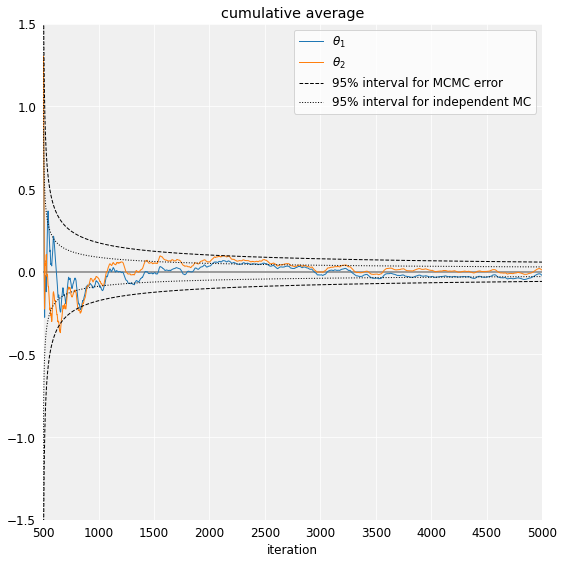

In [42]:
fig = plt.figure(figsize=(8, 8))

indexes = np.arange(burnin, M)
samps = tt[indexes]
nsamps = np.arange(1, len(samps)+1)

# Plotting cumulative averages for theta1 and theta2 behavior separately similarly as earlier.
ax1 = fig.add_subplot(1, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(
    indexes,
    np.cumsum(samps, axis=0) / nsamps[:,None],
    linewidth=1
)

# Plotting 95% interval for MCMC error
er1, = ax1.plot(
    indexes, 1.96/np.sqrt(nsamps/4), 'k--', linewidth=1)
ax1.plot(indexes, -1.96/np.sqrt(nsamps/4), 'k--', linewidth=1)

# Plotting 95% interval for independent MC
er2, = ax1.plot(
    indexes, 1.96/np.sqrt(nsamps), 'k:', linewidth=1)
ax1.plot(indexes, -1.96/np.sqrt(nsamps), 'k:', linewidth=1)

# axis label and title
ax1.set_xlabel('iteration')
ax1.set_title('cumulative average')

# Plotting legend
ax1.legend(
    (line1, line2, er1, er2),
    (r'$\theta_1$', r'$\theta_2$',
      '95% interval for MCMC error',
      '95% interval for independent MC'
    )
)
ax1.set_xlim([burnin, 5000])
ax1.set_ylim([-1.5, 1.5])

fig.tight_layout()

# 7. Metropolis sampling + convergence 2

As I understood, this is the example 2 of :https://github.com/avehtari/BDA_py_demos/blob/master/demos_ch11/demo11_2.ipynb

Which is same thing, but with rho = 0.99

In [43]:
# parameters 
y1 = 0  # mean of the first dimension
y2 = 0  # mean of the second dimension
rho = 0.99  # covariance 
S = np.array([[1.0, rho], [rho, 1.0]]) # covariance within both dimensions is 1.0, as written above

# starting value of the chain
t1 = -2.5 # first dimension
t2 = 2.5 #second dimension

M = 5000 #Iteration number. It does not multiply 2, because we don't iterate for each parameter

# Gibbs sampling here

# allocate memory for the samples
tt = np.empty((M, 2))
tt[0] = [t1, t2]    # Save starting point

# load pre-computed values for demonstration
# download at bda3 site

res = np.loadtxt('demo11_2b.csv', skiprows=1, usecols = (1,2), delimiter = ',')
tt = res
print('loaded pre-computed values in variable `tt`')
print('shape:{}, dtype:{}'.format(tt.shape, tt.dtype))


loaded pre-computed values in variable `tt`
shape:(5000, 2), dtype:float64


Next is same procedure with question 5, with litte difference like burn-in

In [44]:
tt# plotting grid
Y1 = np.linspace(-4.5, 4.5, 150)
Y2 = np.linspace(-4.5, 4.5, 150)

burnin = 500
q = np.sort(np.sqrt(linalg.eigh(S, eigvals_only=True)) * 2.147) 

def add90hpd(ax):
    """Plot 90hpd region into the given axis"""
    el = mpl.patches.Ellipse(
        xy = (y1,y2), #center point of the ellipse
        width = 2 * q[1], # q[1] is larger semimajor axis of the ellipse. Scaling by two gives the larger 
                          # major axis (diameter in the wider direction) 
        height = 2 * q[0], # q[0] is smaller semimajor axis of the ellipse. Scaling by two gives the smaller 
                           # major axis (diameter in the narrower direction) 
        angle = 45, #angle of the ellipse is 45 degrees (pi/4) as mentioned earlier
        facecolor = 'none',
        edgecolor = 'C1'
    )
    ax.add_artist(el)

The next graphs show how the process works, comparing before and after removal of burn-in periods


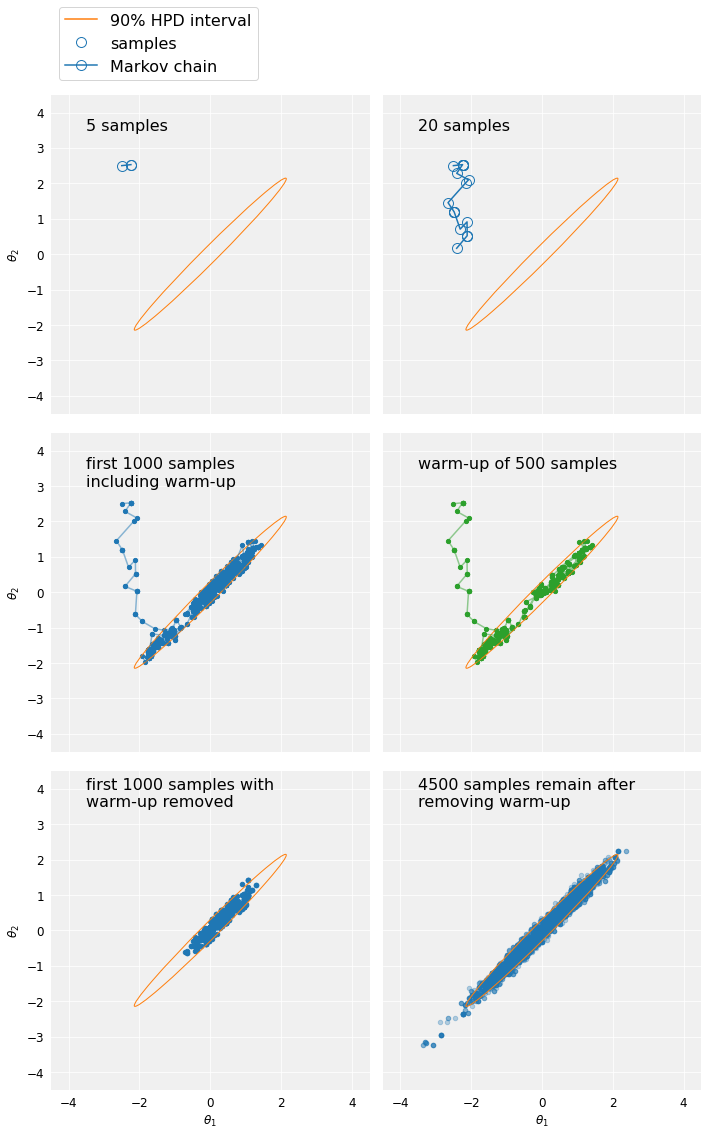

In [45]:
# create the plots
subplotshape = (3, 2)
fig, axes = plt.subplots(
    subplotshape[0], subplotshape[1], sharex=True, sharey=True,
    figsize=(10,16), subplot_kw=dict(aspect='equal')
)

# set limits for axes
axes[0,0].set_xlim([-4.5, 4.5])
axes[0,0].set_ylim([-4.5, 4.5])

# set labels for x- and y-axes
for i in range(subplotshape[0]):
    axes[i,0].set_ylabel(r'$\theta_2$')
for j in range(subplotshape[1]):
    axes[-1,j].set_xlabel(r'$\theta_1$')

# add a shared legend
axes[0,0].legend(
    (   mpl.lines.Line2D([], [], color='C1'), 
        mpl.lines.Line2D(
            [], [], linestyle='', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], color='C0', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C0'
        ),
        mpl.lines.Line2D(
            [], [], color='m', marker='o', markersize=10,
            markerfacecolor='none', markeredgecolor='C2'
        )
    ),
    (   '90% HPD interval',
        'samples',
        'Markov chain'
    ),
    numpoints=1,
    loc='lower left',
    bbox_to_anchor=(0., 1.02, 1., .102),
    fontsize=16
)


# FIRST SUBPLOT
ax = axes[0,0]
add90hpd(ax)
i = 5
line, = ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0') # plot the line between samples

# plot only every other sample as a circle marker
line, = ax.plot(
    tt[:i+1:2,0], tt[:i+1:2,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0')
ax.text(-3.5, 3.5, '5 samples', fontsize=16)

# SECOND SUBPLOT
ax = axes[0,1]
add90hpd(ax)
i = 20
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0')
ax.plot(
    tt[:i+1,0], tt[:i+1,1], 'o', markersize=10,
    markerfacecolor='none', markeredgecolor='C0'
)
ax.text(-3.5, 3.5, '20 samples', fontsize=16)

# THIRD SUBPLOT
ax = axes[1,0]
add90hpd(ax)
i = 1000
ax.plot(tt[:i+1,0], tt[:i+1,1], color='C0', alpha=0.5)
ax.scatter(tt[:i+1,0], tt[:i+1,1], 18, color='C0')
ax.text(-3.5, 3.0, 'first 1000 samples\nincluding warm-up', fontsize=16)

#FOURTH SUBPLOT
ax = axes[1,1]
add90hpd(ax)
# plotting warm-up
ax.plot(tt[:burnin,0], tt[:burnin,1], color='C2', alpha=0.5)
ax.scatter(tt[:burnin,0], tt[:burnin,1], 18, color='C2')

ax.text(-3.5, 3.5, 'warm-up of 500 samples', fontsize=16)

# FIFTH SUBPLOT
ax = axes[2,0]
add90hpd(ax)
i = 999
ax.scatter(
    tt[burnin:i+1,0], tt[burnin:i+1,1],
    20, color='C0'
)
ax.text(-3.5, 3.5, 'first 1000 samples with\nwarm-up removed', fontsize=16)

# SIXTH SUBPLOT
ax = axes[2,1]
add90hpd(ax)
ax.scatter(
    tt[burnin:,0], tt[burnin:,1], 20,
    color='C0', alpha=0.3
)
ax.text(-3.5, 3.5, '4500 samples remain after\nremoving warm-up', fontsize=16)

fig.tight_layout()

We can see that for the final graph, aroud 90% of points are located in 90% HPD,

Meaning it works properly.

However, we still need to check by diagnostics.


The difference with gibbs- sampling could be seen that from the first graph, 

although 5 points are simulated, only 2 are shown, which menas 3 are rejected.

### Convergence Diagonostics

Showing good R-hat(<1.1)


In [46]:
indexes = np.arange(burnin, M, 2) # every other index after burnin
samps = tt[indexes] # choose only samples after burnin

samples = az.convert_to_inference_data({r"$\theta$": samps.T})

az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$\theta$,0.038,0.967,-1.596,1.725,0.108,0.077,82.0,168.0,1.04


###  Visual convergence diagnostics

By cumulative sum, we can see it finally converge after around 4~5 thousands iteration. We need to simulate more times, or have to choose other method

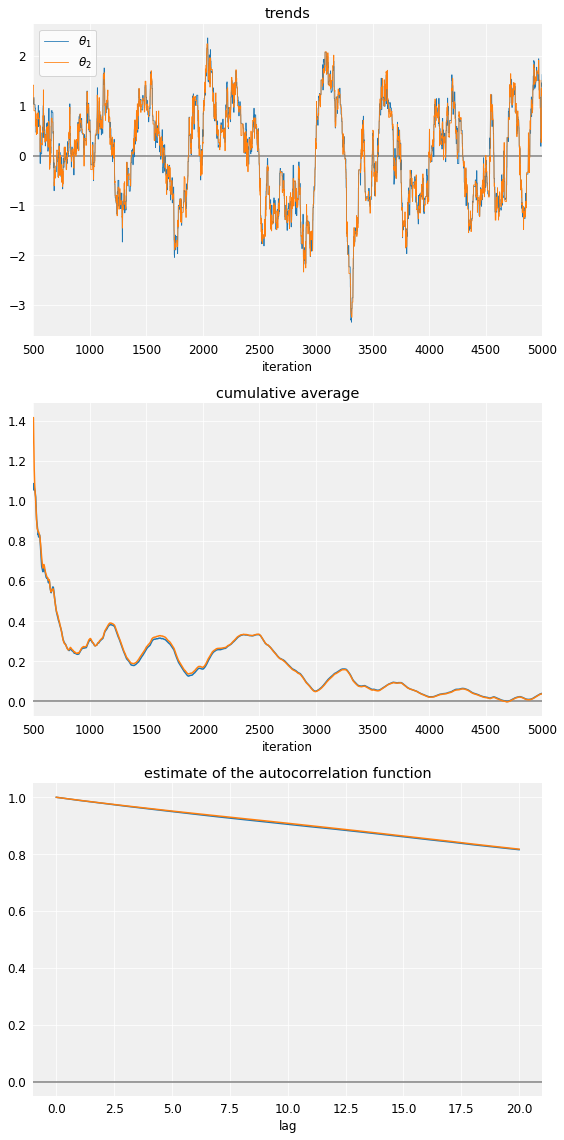

In [47]:
plt.style.use(plot_tools.custom_styles['gray_background'])

fig = plt.figure(figsize=(8, 16))

indexes = np.arange(burnin, M)
samps = tt[indexes] # choose only samples after burnin

# Plotting trends for theta1 and theta2 behavior separately. Only 4500 samples after warm-up included.
ax1 = fig.add_subplot(3, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(indexes, samps, linewidth=0.8) # create lines for both theta1 and theta2 samples
ax1.legend((line1, line2), (r'$\theta_1$', r'$\theta_2$'))
ax1.set_xlabel('iteration')
ax1.set_title('trends')
ax1.set_xlim([burnin, 5000])

# Plotting cumulative averages for theta1 and theta2 behavior separately. Only 4500 samples after warm-up included.
ax2 = fig.add_subplot(3, 1, 2)
ax2.axhline(y=0, color='gray')
ax2.plot(
    indexes,
    np.cumsum(samps, axis=0)/np.arange(1,len(samps)+1)[:,None] # cumulative sum divided by the number of samples
)
ax2.set_xlabel('iteration')
ax2.set_title('cumulative average')
ax2.set_xlim([burnin, 5000])

# Plotting estimated autocorrelation for theta1 and theta2 behavior separately. Only 4500 samples after warm-up included.
ax3 = fig.add_subplot(3, 1, 3)
maxlag = 20 # maximum lag for autocorrelation
sampsc = samps - np.mean(samps, axis=0) # scale the samples by deducting the mean
acorlags = np.arange(maxlag+1) # lags from 0 to maxlag
ax3.axhline(y=0, color='gray')
# calculate autocorrelation for all different lags
for i in [0,1]: # loop for theta1 and theta2
    t = np.correlate(sampsc[:,i], sampsc[:,i], 'full') # autocorrelation with full range of lags
    t = t[-len(sampsc):-len(sampsc)+maxlag+1] / t[-len(sampsc)] # choose only the lags that we want to use
    ax3.plot(acorlags, t)
ax3.set_xlabel('lag')
ax3.set_title('estimate of the autocorrelation function')

fig.tight_layout()

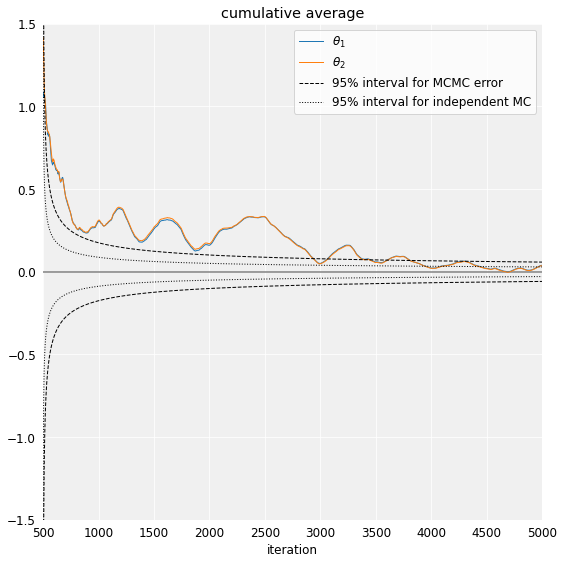

In [48]:
fig = plt.figure(figsize=(8, 8))

indexes = np.arange(burnin, M)
samps = tt[indexes]
nsamps = np.arange(1, len(samps)+1)

# Plotting cumulative averages for theta1 and theta2 behavior separately similarly as earlier.
ax1 = fig.add_subplot(1, 1, 1)
ax1.axhline(y=0, color='gray')
line1, line2, = ax1.plot(
    indexes,
    np.cumsum(samps, axis=0) / nsamps[:,None],
    linewidth=1
)

# Plotting 95% interval for MCMC error
er1, = ax1.plot(
    indexes, 1.96/np.sqrt(nsamps/4), 'k--', linewidth=1)
ax1.plot(indexes, -1.96/np.sqrt(nsamps/4), 'k--', linewidth=1)

# Plotting 95% interval for independent MC
er2, = ax1.plot(
    indexes, 1.96/np.sqrt(nsamps), 'k:', linewidth=1)
ax1.plot(indexes, -1.96/np.sqrt(nsamps), 'k:', linewidth=1)

# axis label and title
ax1.set_xlabel('iteration')
ax1.set_title('cumulative average')

# Plotting legend
ax1.legend(
    (line1, line2, er1, er2),
    (r'$\theta_1$', r'$\theta_2$',
      '95% interval for MCMC error',
      '95% interval for independent MC'
    )
)
ax1.set_xlim([burnin, 5000])
ax1.set_ylim([-1.5, 1.5])

fig.tight_layout()

# 8. Inverse - CDF method for Weibull Distribution

for $x \quad \sim \quad Weibull(\alpha, \lambda)$,  CDF $F(x)$  = $1-e^{-(\lambda x)^\alpha} $

culating inverse,

$1-e^{-(\lambda x)^\alpha} = u   \quad \rightarrow \quad 1-u = e^{-(\lambda x)^{\alpha}} \rightarrow \quad -ln(1-u) = (\lambda x  )^\alpha \rightarrow \\ x = \frac{1}{\lambda} (-ln(1-u))^\frac{1}{\alpha} \rightarrow \quad x =  \frac{1}{\lambda} (-ln(u))^\frac{1}{\alpha}  $

In [ ]:
lamb = 1
alpha = 1

u = np.random.uniform(size = 10000)
x = 1/lamb * ((-np.log(u))**(1/alpha))

lamb = 1
alpha = 2
uu = np.random.uniform(size = 10000)
xx = 1/lamb * ((-np.log(uu))**(1/alpha))

lamb = 1
alpha = 3
uuu = np.random.uniform(size = 10000)
xxx = 1/lamb * ((-np.log(uuu))**(1/alpha))


drawing histograms, they follow the usual weibull distribution shape

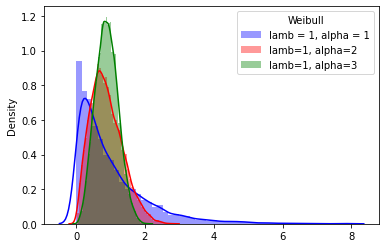

In [ ]:
import seaborn as sns
sns.distplot(x,  color="blue", label="lamb = 1, alpha = 1")
sns.distplot(xx,   color="red", label="lamb=1, alpha=2")
sns.distplot(xxx, color="green", label="lamb=1, alpha=3")
plt.legend(title="Weibull")
plt.show()

# 9.Implement Box-Muller

when u1 follows uniform, u2 follows normal, independently, 

$X1 = \sqrt{-2 log u_2} cos(2 \pi u_1 ) \\  X2 = \sqrt{-2 log u_2} sin(2 \pi u_1 ) $

 both follow $Normal(0,1)$, suggested in lecture





In [ ]:
u1 = np.random.uniform(size = 10000)
u2 = np.random.uniform(size = 10000)

x1 = np.sqrt(-2*np.log(u1))*np.cos(2*math.pi*u2)
x2 = np.sqrt(-2*np.log(u1))*np.sin(2*math.pi*u2)

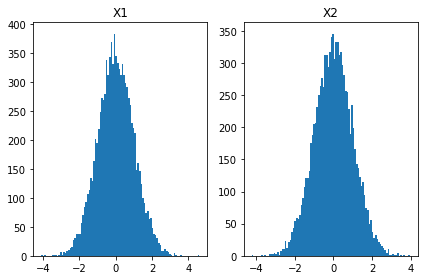

In [ ]:
plt.subplot(1,2,1)
plt.hist(x1, bins = 100)
plt.title('X1')

plt.subplot(1,2,2)
plt.hist(x2, bins = 100)
plt.title('X2')

plt.tight_layout()
plt.show()

We could see that both follows normal shape

In [ ]:
print('X1 mean :', np.mean(x1), 'X1 standard deviation: ',  np.std(x1))
print('X2 mean :', np.mean(x2), 'X2 standard deviation: ',  np.std(x2))

X1 mean : 0.004742001977523901 X1 standard deviation:  0.9949080890797275
X2 mean : 0.003617101253235275 X2 standard deviation:  1.0012011587520562


Also, they have 0 mean and 1 std, as suggested in class.

# 10.CH10-3

(a) 

From beta-binomial, posterior is,

## $p_i \quad \sim \quad Beta(\alpha_i +y_i ,\beta_i +n_i -y_i)$ $for $ $i = 1,2$ 

In [ ]:
#  Jefferey prior : alpha,beta= 1/2

n1=10; n2=20 ; y1=6; y2=10;

# alpha=beta=1/2
alpha = 1/2 ; beta = 1/2;
posterior_1 = np.random.beta(alpha +y1,  beta +n1-y1, size = 100000)
posterior_2 = np.random.beta(alpha +y2,  beta +n2-y2, size = 100000)

p1_p2_1 = posterior_1 - posterior_2
quantile_1 = np.quantile(p1_p2_1, [0.025,0.975])

#alpha1=1, beta1=30, alpha2=10,beta2=10
alpha1 = 1 ; beta1 = 30; alpha2=10; beta2=10
posterior_1 = np.random.beta(alpha1 +y1,  beta1 +n1-y1, size = 100000)
posterior_2 = np.random.beta(alpha2 +y2,  beta2 +n2-y2, size = 100000)

p1_p2_2 = posterior_1 - posterior_2
quantile_2 = np.quantile(p1_p2_2, [0.025,0.975])

#alpha1=30, beta1=1, alpha2=10,beta2=10
alpha1 = 30 ; beta1 = 1; alpha2=10; beta2=10
posterior_1 = np.random.beta(alpha1 +y1,  beta1 +n1-y1, size = 100000)
posterior_2 = np.random.beta(alpha2 +y2,  beta2 +n2-y2, size = 100000)

p1_p2_3 = posterior_1 - posterior_2
quantile_3 = np.quantile(p1_p2_3, [0.025,0.975])


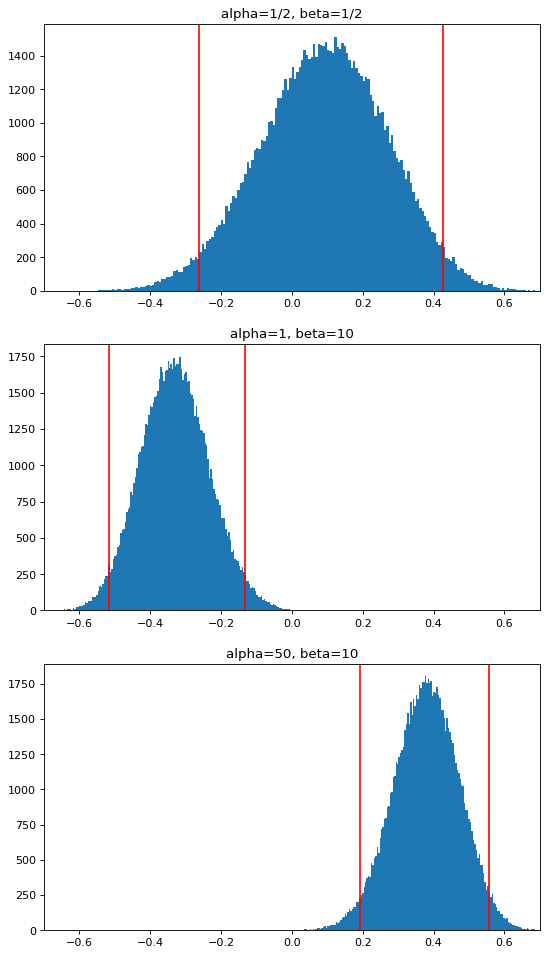

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(8, 15), dpi=80)

plt.subplot(3,1,1)
plt.hist(p1_p2_1, bins = 200)
plt.axvline(x = quantile_1[0], color= 'r', label = 'red')
plt.axvline(x = quantile_1[1], color= 'r', label = 'red')
plt.xlim(-0.7,0.7)
plt.title('alpha=1/2, beta=1/2')

plt.subplot(3,1,2)
plt.hist(p1_p2_2, bins = 200)
plt.axvline(x = quantile_2[0], color= 'r', label = 'red')
plt.axvline(x = quantile_2[1], color= 'r', label = 'red')
plt.xlim(-0.7,0.7)
plt.title('alpha=1, beta=10')

plt.subplot(3,1,3)
plt.hist(p1_p2_3, bins = 200)
plt.axvline(x = quantile_3[0], color= 'r', label = 'red')
plt.axvline(x = quantile_3[1], color= 'r', label = 'red')
plt.xlim(-0.7,0.7)
plt.title('alpha=50, beta=10')

plt.show()


1. alpha=beta= 1/2 is non-informative, suggesting data information : [-0.24,0.41] for 95% CI

2. alpha1=1, beta1=30, alpha2=10, beta2=10,

    Put prior belief that p1<p2, therefore p1-p2 more goes to minus

3. alpha1=30, beta1=1, alpha2=10, beta2=10,

    Put prior belief that p1>p2, therefore p1-p2 more goes to plus



In [ ]:
#(b)
#1. alpha=beta=1/2
print('alpha=beta=1/2:                          ', len(p1_p2_1[p1_p2_1>0])/len(p1_p2_1))
#2. alpha1=1, beta1=30, alpha2=10,beta2=10
print('alpha1=1, beta1=30, alpha2=10,beta2=10:  ', len(p1_p2_2[p1_p2_2>0])/len(p1_p2_2))
#3. alpha1=30, beta1=1, alpha2=10,beta2=10
print(' alpha1=30, beta1=1, alpha2=10,beta2=10: ',len(p1_p2_3[p1_p2_3>0])/len(p1_p2_3))

alpha=beta=1/2:                           0.69628
alpha1=1, beta1=30, alpha2=10,beta2=10:   0.00057
 alpha1=30, beta1=1, alpha2=10,beta2=10:  0.99995
